# Ross Sea sea ice dynamics
## Level sea ice freeboard & ridge height/fraction

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
# import time
import pandas as pd
from tqdm import tqdm
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
from shapely.geometry import Point
import geopandas
import scipy.stats as stats
import netCDF4
from netCDF4 import Dataset    # Note: python is case-sensitive!
from netCDF4 import date2num,num2date

from pyproj import Proj, transform
from shapely.geometry import Polygon
from sklearn.neighbors import KernelDensity

import utils as ut

from tqdm import tqdm
import matplotlib.ticker as mticker

# from mpl_toolkits.basemap import Basemap

%load_ext autoreload
%autoreload 2

from readers import *


## Read data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset    # Note: python is case-sensitive!
from netCDF4 import date2num,num2date
import datetime as dt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [3]:
year = 2019

try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass

ncname = f'D:\\Ross\\ATL10_processed_nc\\Freeboard_ridges_density_{year}.nc'
ds = xr.open_dataset(ncname)

with netCDF4.Dataset(ncname, 'r') as nc:
    keys = nc.variables.keys()
    fb_mode = np.array(nc.variables['fb_mode'])
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x, y)
    
    times = nc.variables['time']
    times = num2date(times[:], units = times.units)

    hours = np.array(nc.variables['time']).astype(float)
    time_era = []

    for i in range(0, len(hours)):
        time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))
    print(keys)

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])


In [4]:
NW = (lat>-74) & (lat<-70) & ((lon<-172) | (lon>168))
SW = (lat>-78) & (lat<-74) & ((lon<-172) | (lon>168))
SE = (lat>-78) & (lat<-74) & ((lon<-150) & (lon>-172))
NE = (lat>-74) & (lat<-70) & ((lon<-150) & (lon>-172))

from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3412")

In [5]:
offset = 0.0

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

In [470]:
xx.shape

(96, 141)

In [7]:
# Draw map ===========================================================

for year in [2018, 2019, 2020, 2021, 2022]:
    
    ##### Read data ##############################
    try: ncfile.close()  # just to be safe, make sure dataset is not already open.
    except: pass

    ncname = f'D:\\Ross\\ATL10_processed_nc\\Ridges_density_{year}.nc'
    ds = xr.open_dataset(ncname)

    with netCDF4.Dataset(ncname, 'r') as nc:
        lat = np.array(nc.variables['lat'])
        lon = np.array(nc.variables['lon'])
        x = np.array(nc.variables['x'])
        y = np.array(nc.variables['y'])
        xx, yy = np.meshgrid(x, y)

        times = nc.variables['time']
        times = num2date(times[:], units = times.units)

        hours = np.array(nc.variables['time']).astype(float)
        time_era = []

        for i in range(0, len(hours)):
            time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))
        print(keys)
    #################################################

    # date1 = [dt.datetime(year,3,1), dt.datetime(year,4,1), dt.datetime(year,5,1), dt.datetime(year,6,1),
    #          dt.datetime(year,7,1), dt.datetime(year,8,1), dt.datetime(year,9,1), dt.datetime(year,10,1)]
    # date2 = [dt.datetime(year,5,31), dt.datetime(year,6,30), dt.datetime(year,7,31), dt.datetime(year,8,31),
    #          dt.datetime(year,9,30), dt.datetime(year,10,31), dt.datetime(year,11,30), dt.datetime(year,12,31)]

    date1 = [dt.datetime(year,4,1), dt.datetime(year,7,1), dt.datetime(year,10,1)]
    date_m = [dt.datetime(year,5,1), dt.datetime(year,8,1), dt.datetime(year,11,1)]
    date2 = [dt.datetime(year,6,30), dt.datetime(year,9,30), dt.datetime(year,12,31)]

    # date1 = [dt.datetime(year,10,1)]
    # date2 = [dt.datetime(year,12,31)]
    labels = {'fb_mode': 'Modal freeboard (m)', 'fb_mean': 'Mean freeboard (m)', 'fb_median': 'Median freeboard (m)', 'fb_std': 'Surface roughness (m)',
              'h_ridge': 'Ridge height (m)', 'fr_ridge': 'Ridge fraction (%)', 'fr_lead': 'Lead fraction (%)'}
    
    for field1 in ['fb_mode', 'fb_std', 'fr_ridge', 'h_ridge']:
        for i in range(0, len(date1)):

        #     fig = plt.figure(figsize=(8,4), dpi= 100)
        #     ax = plt.axes(projection=ccrs.SouthPolarStereo())

            fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})

            lons = np.arange(-180, -89)   

            ax.plot(NW_x, NW_y, lw=1.5, color = "magenta")
            ax.plot(NE_x, NE_y, lw=1.5, color = "magenta")
            ax.plot(SW_x, SW_y, lw=1.5, color = "magenta")
            ax.plot(SE_x, SE_y, lw=1.5, color = "magenta")


            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                              linewidth=0.5, color='grey', linestyle='--')

            # gl.xformatter = LONGITUDE_FORMATTER
            # gl.yformatter = LATITUDE_FORMATTER
            # gl.xlabel_style = {'size': 12, 'color': 'gray'}
            gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 30}
            gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
            gl.top_labels = False #False #False #False
            gl.bottom_labels = False #False #False
    
            ax[i,j].annotate('180°', xy=(0.33, 1.0), xycoords='axes fraction', rotation = 90, size = 7, va = 'top', ha ='right')
            ax[i,j].annotate('150°W',xy=(0.83, 1.0), xycoords='axes fraction', rotation = 60, size = 7, va = 'top', ha ='right')

            # gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

        #     N = np.array(nc.variables['N'])

            tidx = (times >= date1[i]) & (times < date2[i])
            fb_count = np.nansum(np.transpose(np.array(ds.variables["fb_count"][tidx, :, :]), axes = (0, 2, 1)), axis = 0)
            valid_count = (fb_count > 500)
            
            h_ridge = np.transpose(np.array(ds.variables['h_ridge'][tidx, :, :]), axes = (0, 2, 1))
            valid_ridge = (h_ridge < 1.0)
            
            if np.sum(tidx) > 0:
                # field1 = 'h_ridge'
                array = np.transpose(np.array(ds.variables[field1][tidx, :, :]), axes = (0, 2, 1))
                if field1 in ["fr_ridge", "h_ridge"]:
                    array[~valid_ridge] = np.nan
                    # if field1 == "h_ridge":
                    #     array = array - 0.6
                data1 = np.nanmedian(array, axis = 0)
                data1[~valid_count] = np.nan

                vmin, vmax = {}, {};
                vmin['fb_mode'] = 0.0; vmax['fb_mode'] = 0.5
                vmin['fb_mode1'] = 0.0; vmax['fb_mode1'] = 0.5
                vmin['fb_mode2'] = 0.0; vmax['fb_mode2'] = 0.5
                vmin['fr_ridge'] = 0.0; vmax['fr_ridge'] = 10
                vmin['fb_mean'] = 0.0; vmax['fb_mean'] = 0.8
                vmin['fb_median'] = 0.0; vmax['fb_median'] = 0.8
                vmin['fb_std'] = 0.0; vmax['fb_std'] = 0.5
                vmin['fr_lead'] = 0.0; vmax['fr_lead'] = 0.02
                vmin['h_ridge'] = 0.0; vmax['h_ridge'] = 0.4

                pm = ax.pcolormesh(xx, yy, data1, cmap = "jet", vmin = vmin[field1], vmax = vmax[field1])

                xmin, xmax = ax.set_xlim(1100000, -1800000)
                ymin, ymax = ax.set_ylim(-800000, -3200000)
                
                ax.annotate('', xy=(xmax+100000,ymax+150000), xytext=(xmax+600000, ymax+150000), arrowprops=dict(arrowstyle='<->'))
                ax.annotate('500km', xy=(xmax+100000,ymax+200000), xytext=(xmax+600000, ymax+200000), va = "top")

                # ax.set_title("{0} ({1}-{2})".format(field2, date1[i].strftime("%b"), date2[i].strftime("%b %Y")),
                #                fontsize = 12)
                ax.annotate("{0}{1}{2} {3}".format(date1[i].strftime("%b")[0], date_m[i].strftime("%b")[0], date2[i].strftime("%b")[0], year), xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')

                ax.coastlines('10m', linewidth = 0.5)
                ax.add_feature(cfeature.LAND)

                cb = plt.colorbar(pm, ax = ax, shrink = 0.5, pad = 0.04)
                cb.set_label(f"{labels[field1]}", rotation = 270, va = "bottom")

                plt.savefig("D:\\Ross\\Figures_map\\{0}_{1}-{2}.png".format(field1, date1[i].strftime("%Y%m"), date2[i].strftime("%Y%m")),
                           bbox_inches="tight")
                
            plt.close()

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])


In [40]:
# Draw map for multi-panels (dynamic features) ===========================================================
vmin, vmax = {}, {};
vmin['fb_mode'] = 0.0; vmax['fb_mode'] = 0.5
vmin['fb_mode1'] = 0.0; vmax['fb_mode1'] = 0.5
vmin['fb_mode2'] = 0.0; vmax['fb_mode2'] = 0.5
vmin['fr_ridge'] = 0.0; vmax['fr_ridge'] = 10
vmin['fb_mean'] = 0.0; vmax['fb_mean'] = 0.8
vmin['fb_median'] = 0.0; vmax['fb_median'] = 0.8
vmin['fb_std'] = 0.0; vmax['fb_std'] = 0.5
vmin['fr_lead'] = 0.0; vmax['fr_lead'] = 0.02
vmin['h_ridge'] = 0.6; vmax['h_ridge'] = 1.0

fig, ax = plt.subplots(3,4, figsize = (4*3.02, 3*2.5), dpi= 100,
                       subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
plt.subplots_adjust(hspace=0.04, wspace=0.04)

cb_ax = fig.add_axes([.91,.4,.01,.2])

for j,year in enumerate([2019, 2020, 2021, 2022]):
    
    ##### Read data ##############################
    try: ncfile.close()  # just to be safe, make sure dataset is not already open.
    except: pass

    ncname = f'D:\\Ross\\ATL10_processed_nc\\Ridges_density_{year}.nc'
    ds = xr.open_dataset(ncname)

    with netCDF4.Dataset(ncname, 'r') as nc:
        lat = np.array(nc.variables['lat'])
        lon = np.array(nc.variables['lon'])
        x = np.array(nc.variables['x'])
        y = np.array(nc.variables['y'])
        xx, yy = np.meshgrid(x, y)

        times = nc.variables['time']
        times = num2date(times[:], units = times.units)

        hours = np.array(nc.variables['time']).astype(float)
        time_era = []

        for i in range(0, len(hours)):
            time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))
        print(keys)

    date1 = [dt.datetime(year,4,1), dt.datetime(year,7,1), dt.datetime(year,10,1)]
    date_m = [dt.datetime(year,5,1), dt.datetime(year,8,1), dt.datetime(year,11,1)]
    date2 = [dt.datetime(year,6,30), dt.datetime(year,9,30), dt.datetime(year,12,31)]

    # date1 = [dt.datetime(year,10,1)]
    # date2 = [dt.datetime(year,12,31)]
    labels = {'fb_mode': 'Modal freeboard (m)', 'fb_mean': 'Mean freeboard (m)', 'fb_median': 'Median freeboard (m)', 'fb_std': 'Surface roughness (m)',
              'h_ridge': 'Ridge height (m)', 'fr_ridge': 'Ridge fraction (%)', 'fr_lead': 'Lead fraction (%)'}
    
    # ['fb_std', 'fr_ridge', 'h_ridge']
    for field1 in ['fb_std']:
        for i in range(0, len(date1)):

            
            lons = np.arange(-180, -89)   

            ax[i,j].plot(NW_x, NW_y, lw=1.5, color = "magenta")
            ax[i,j].plot(NE_x, NE_y, lw=1.5, color = "magenta")
            ax[i,j].plot(SW_x, SW_y, lw=1.5, color = "magenta")
            ax[i,j].plot(SE_x, SE_y, lw=1.5, color = "magenta")


            gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                               linewidth=0.5, color='k', alpha = 0.5, linestyle='--')

            # gl.xformatter = LONGITUDE_FORMATTER
            # gl.yformatter = LATITUDE_FORMATTER
            # gl.xlabel_style = {'size': 12, 'color': 'gray'}
            gl.ylabel_style = {'size': 8, 'color': 'k', 'ha': 'left', 'rotation': 30}
            gl.xlabel_style = {'size': 8, 'color': 'k', 'ha': 'center', 'rotation': 0}
            gl.top_labels = False #False #False #False
            gl.bottom_labels = False #False #False
    
            ax[i,j].annotate('180°', xy=(0.38, 0.85), xycoords='axes fraction', rotation = 90, size = 8, va = 'top', ha ='right')
            ax[i,j].annotate('150°W',xy=(0.92, 0.85), xycoords='axes fraction', rotation = 60, size = 8, va = 'top', ha ='right')
                

            tidx = np.where((times >= date1[i]) & (times < date2[i]))[0]
            fb_count = np.nansum(np.transpose(np.array(ds.variables["fb_count"][tidx, :, :]), axes = (0, 2, 1)), axis = 0)
            valid_count = (fb_count > 500)


            h_ridge = np.transpose(np.array(ds.variables['h_ridge'][tidx, :, :]), axes = (0, 2, 1))
            valid_ridge = (h_ridge < 1.0)
            
            if np.sum(tidx) > 0:
                # field1 = 'h_ridge'
                array = np.transpose(np.array(ds.variables[field1][tidx, :, :]), axes = (0, 2, 1))
                if field1 in ["fr_ridge", "h_ridge"]:
                    array[~valid_ridge] = np.nan
                    # if field1 == "h_ridge":
                    #     array = array - 0.6
                data1 = np.nanmedian(array, axis = 0)
                data1[~valid_count] = np.nan

                pm = ax[i,j].pcolormesh(xx, yy, data1, cmap = "jet", vmin = vmin[field1], vmax = vmax[field1])

                xmin, xmax = ax[i,j].set_xlim(1100000, -1800000)
                ymin, ymax = ax[i,j].set_ylim(-800000, -3200000)
                
                ax[i,j].annotate('', xy=(xmax+100000,ymax+150000), xytext=(xmax+600000, ymax+150000), arrowprops=dict(arrowstyle='<->'))
                ax[i,j].annotate('500km', xy=(xmax+100000,ymax+200000), xytext=(xmax+600000, ymax+200000), va = "top", fontsize = 9)

                # ax.set_title("{0} ({1}-{2})".format(field2, date1[i].strftime("%b"), date2[i].strftime("%b %Y")),
                #                fontsize = 12)
                ax[i,j].annotate("{0}{1}{2} {3}".format(date1[i].strftime("%b")[0], date_m[i].strftime("%b")[0], date2[i].strftime("%b")[0], year), xy=(0.03, 0.97),
                                 xycoords='axes fraction', fontsize=12, ha='left', va='top')

                ax[i,j].coastlines('10m', linewidth = 0.5)
                ax[i,j].add_feature(cfeature.LAND)

                # cb = plt.colorbar(pm, ax = ax, shrink = 0.5, pad = 0.04)
                # cb.set_label(f"Modal SIT (m)", rotation = 270, va = "bottom")

                if j == 3:
                    
                    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, shrink = 0.5, pad = 0.04)
                    cb.set_label(f"{labels[field1]}", rotation = 270, va = "bottom")

plt.savefig("D:\\Ross\\Figures_map\\{0}.png".format(field1), bbox_inches="tight")

plt.close()

print("Done", field1)

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
Done fb_std


In [37]:
f"{labels[field1]}"

'Ridge height'

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
Done


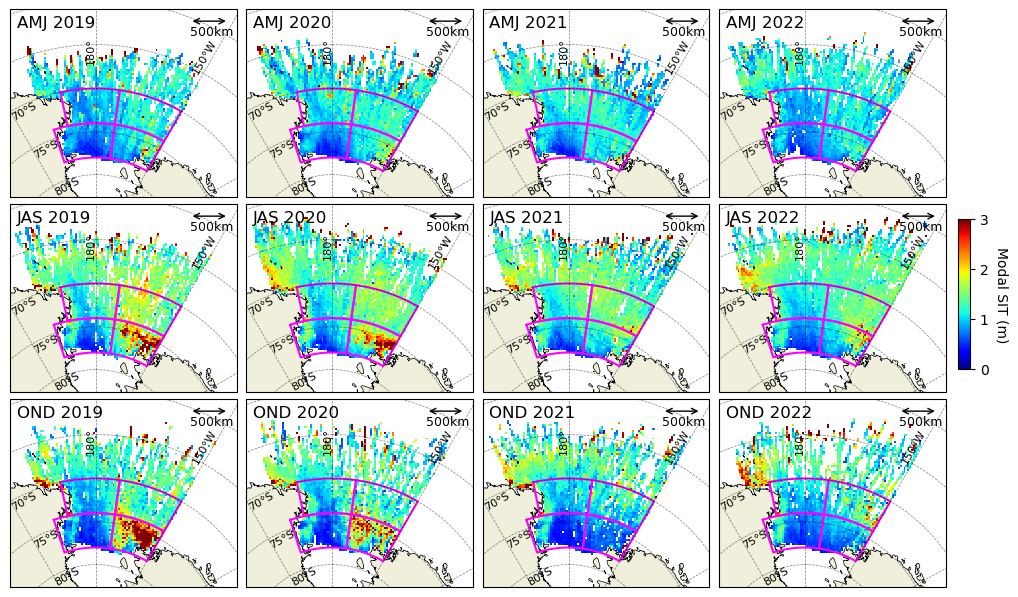

In [23]:
# Draw map for multi-panels (Modal SIT) ===========================================================

fig, ax = plt.subplots(3,4, figsize = (4*3.02, 3*2.5), dpi= 100,
                       subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
plt.subplots_adjust(hspace=0.04, wspace=0.04)

cb_ax = fig.add_axes([.91,.4,.01,.2])

for j,year in enumerate([2019, 2020, 2021, 2022]):
    
    ##### Read data ##############################
    try: ncfile.close()  # just to be safe, make sure dataset is not already open.
    except: pass

    ncname = f'D:\\Ross\\ATL10_processed_nc\\Ridges_density_{year}.nc'
    ds = xr.open_dataset(ncname)

    with netCDF4.Dataset(ncname, 'r') as nc:
        lat = np.array(nc.variables['lat'])
        lon = np.array(nc.variables['lon'])
        x = np.array(nc.variables['x'])
        y = np.array(nc.variables['y'])
        xx, yy = np.meshgrid(x, y)

        times = nc.variables['time']
        times = num2date(times[:], units = times.units)

        hours = np.array(nc.variables['time']).astype(float)
        time_era = []

        for i in range(0, len(hours)):
            time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))
        print(keys)

    date1 = [dt.datetime(year,4,1), dt.datetime(year,7,1), dt.datetime(year,10,1)]
    date_m = [dt.datetime(year,5,1), dt.datetime(year,8,1), dt.datetime(year,11,1)]
    date2 = [dt.datetime(year,6,30), dt.datetime(year,9,30), dt.datetime(year,12,31)]

    # date1 = [dt.datetime(year,10,1)]
    # date2 = [dt.datetime(year,12,31)]
    labels = {'fb_mode': 'Modal freeboard', 'fb_mean': 'Mean freeboard', 'fb_median': 'Median freeboard', 'fb_std': 'Std. freeboard', 'h_ridge': 'Ridge height',
             'fr_ridge': 'Ridge fraction', 'fr_lead': 'Lead fraction'}
    
    for field1 in ['fb_mode', 'fb_std', 'fr_ridge', 'h_ridge']:
        for i in range(0, len(date1)):

            
            lons = np.arange(-180, -89)   

            ax[i,j].plot(NW_x, NW_y, lw=1.5, color = "magenta")
            ax[i,j].plot(NE_x, NE_y, lw=1.5, color = "magenta")
            ax[i,j].plot(SW_x, SW_y, lw=1.5, color = "magenta")
            ax[i,j].plot(SE_x, SE_y, lw=1.5, color = "magenta")


            gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                               linewidth=0.5, color='k', alpha = 0.5, linestyle='--')

            # gl.xformatter = LONGITUDE_FORMATTER
            # gl.yformatter = LATITUDE_FORMATTER
            # gl.xlabel_style = {'size': 12, 'color': 'gray'}
            gl.ylabel_style = {'size': 8, 'color': 'k', 'ha': 'left', 'rotation': 30}
            gl.xlabel_style = {'size': 8, 'color': 'k', 'ha': 'center', 'rotation': 0}
            gl.top_labels = False #False #False #False
            gl.bottom_labels = False #False #False
    
            ax[i,j].annotate('180°', xy=(0.38, 0.85), xycoords='axes fraction', rotation = 90, size = 8, va = 'top', ha ='right')
            ax[i,j].annotate('150°W',xy=(0.92, 0.85), xycoords='axes fraction', rotation = 60, size = 8, va = 'top', ha ='right')
                

            tidx = np.where((times >= date1[i]) & (times < date2[i]))[0]
            fb_count = np.nansum(np.transpose(np.array(ds.variables["fb_count"][tidx, :, :]), axes = (0, 2, 1)), axis = 0)
            valid_count = (fb_count > 500)
            
            if np.sum(tidx) > 0:
                # field1 = 'h_ridge'     
                        
                fb_mean = np.transpose(np.array(ds.variables['fb_mean'][tidx, :, :]), axes = (0, 2, 1))
                fb_med = np.transpose(np.array(ds.variables['fb_med'][tidx, :, :]), axes = (0, 2, 1))
                fb_mode = np.transpose(np.array(ds.variables['fb_mode'][tidx, :, :]), axes = (0, 2, 1))
                hs = np.zeros(fb_mean.shape)
                hi = np.zeros(fb_mean.shape)
                for snow_method in ["KK"]:
                    for n, k in enumerate(tidx):
                        hs[n] = snow_depth(fb_mode[n], xx, yy, time_era[k], method = snow_method)
                        hi[n] = ice_thickness(fb_mode[n], hs[n])
                
                data1 = np.nanmean(hi, axis = 0)
                data1[~valid_count] = np.nan

                pm = ax[i,j].pcolormesh(xx, yy, data1, cmap = "jet", vmin = 0, vmax = 3)

                xmin, xmax = ax[i,j].set_xlim(1100000, -1800000)
                ymin, ymax = ax[i,j].set_ylim(-800000, -3200000)
                
                ax[i,j].annotate('', xy=(xmax+100000,ymax+150000), xytext=(xmax+600000, ymax+150000), arrowprops=dict(arrowstyle='<->'))
                ax[i,j].annotate('500km', xy=(xmax+100000,ymax+200000), xytext=(xmax+600000, ymax+200000), va = "top", fontsize = 9)

                # ax.set_title("{0} ({1}-{2})".format(field2, date1[i].strftime("%b"), date2[i].strftime("%b %Y")),
                #                fontsize = 12)
                ax[i,j].annotate("{0}{1}{2} {3}".format(date1[i].strftime("%b")[0], date_m[i].strftime("%b")[0], date2[i].strftime("%b")[0], year), xy=(0.03, 0.97),
                                 xycoords='axes fraction', fontsize=12, ha='left', va='top')

                ax[i,j].coastlines('10m', linewidth = 0.5)
                ax[i,j].add_feature(cfeature.LAND)

                # cb = plt.colorbar(pm, ax = ax, shrink = 0.5, pad = 0.04)
                # cb.set_label(f"Modal SIT (m)", rotation = 270, va = "bottom")

                if j == 3:
                    
                    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, shrink = 0.5, pad = 0.04)
                    cb.set_label(f"Modal SIT (m)", rotation = 270, va = "bottom")

plt.savefig("D:\\Ross\\Figures_map\\hi_{0}.png".format(snow_method), bbox_inches="tight")

# plt.close()

print("Done")

In [520]:
np.sum(valid_ridge)

0

### Level ice thickness

In [628]:
# Draw map ===========================================================

for year in [2018, 2019, 2020, 2021, 2022]:
    
    ##### Read data ##############################
    try: ncfile.close()  # just to be safe, make sure dataset is not already open.
    except: pass

    ncname = f'D:\\Ross\\ATL10_processed_nc\\Ridges_density_{year}.nc'
    ds = xr.open_dataset(ncname)

    with netCDF4.Dataset(ncname, 'r') as nc:
        lat = np.array(nc.variables['lat'])
        lon = np.array(nc.variables['lon'])
        x = np.array(nc.variables['x'])
        y = np.array(nc.variables['y'])
        xx, yy = np.meshgrid(x, y)

        times = nc.variables['time']
        times = num2date(times[:], units = times.units)

        hours = np.array(nc.variables['time']).astype(float)
        time_era = []

        for i in range(0, len(hours)):
            time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))
        print(keys)
    #################################################

    # date1 = [dt.datetime(year,3,1), dt.datetime(year,4,1), dt.datetime(year,5,1), dt.datetime(year,6,1),
    #          dt.datetime(year,7,1), dt.datetime(year,8,1), dt.datetime(year,9,1), dt.datetime(year,10,1)]
    # date2 = [dt.datetime(year,5,31), dt.datetime(year,6,30), dt.datetime(year,7,31), dt.datetime(year,8,31),
    #          dt.datetime(year,9,30), dt.datetime(year,10,31), dt.datetime(year,11,30), dt.datetime(year,12,31)]

    date1 = [dt.datetime(year,4,1), dt.datetime(year,7,1), dt.datetime(year,10,1)]
    date_m = [dt.datetime(year,5,1), dt.datetime(year,8,1), dt.datetime(year,11,1)]
    date2 = [dt.datetime(year,6,30), dt.datetime(year,9,30), dt.datetime(year,12,31)]

    # date1 = [dt.datetime(year,10,1)]
    # date2 = [dt.datetime(year,12,31)]
    labels = {'fb_mode': 'Modal freeboard', 'fb_mean': 'Mean freeboard', 'fb_median': 'Median freeboard', 'fb_std': 'Std. freeboard', 'h_ridge': 'Ridge height',
             'fr_ridge': 'Ridge fraction', 'fr_lead': 'Lead fraction'}
    
    for field1 in ['fb_mode']:
        for i in range(0, len(date1)):

        #     fig = plt.figure(figsize=(8,4), dpi= 100)
        #     ax = plt.axes(projection=ccrs.SouthPolarStereo())

            fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})

            lons = np.arange(-180, -89)   

            ax.plot(NW_x, NW_y, lw=1.5, color = "magenta")
            ax.plot(NE_x, NE_y, lw=1.5, color = "magenta")
            ax.plot(SW_x, SW_y, lw=1.5, color = "magenta")
            ax.plot(SE_x, SE_y, lw=1.5, color = "magenta")


            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                              linewidth=0.5, color='grey', linestyle='--')

            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            # gl.xlabel_style = {'size': 12, 'color': 'gray'}
            gl.ylabel_style = {'size': 9, 'color': 'k', 'ha': 'left', 'rotation': 30}
            gl.xlabels_top = False
            gl.xlabels_bottom = False
            gl.ylabels_left = True
            gl.ylabels_right = True
            # gl.Gridliner(axes, crs, draw_labels=False, xlocator=None, ylocator=None, collection_kwargs=None)[source]

            # gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

        #     N = np.array(nc.variables['N'])

            tidx = np.where((times >= date1[i]) & (times < date2[i]))[0]
            fb_count = np.nansum(np.transpose(np.array(ds.variables["fb_count"][tidx, :, :]), axes = (0, 2, 1)), axis = 0)
            valid_count = (fb_count > 500)
            
            if np.sum(tidx) > 0:
                # field1 = 'h_ridge'     
                        
                fb_mean = np.transpose(np.array(ds.variables['fb_mean'][tidx, :, :]), axes = (0, 2, 1))
                fb_med = np.transpose(np.array(ds.variables['fb_med'][tidx, :, :]), axes = (0, 2, 1))
                fb_mode = np.transpose(np.array(ds.variables['fb_mode'][tidx, :, :]), axes = (0, 2, 1))
                hs = np.zeros(fb_mean.shape)
                hi = np.zeros(fb_mean.shape)
                for snow_method in ["KK"]:
                    for n, k in enumerate(tidx):
                        hs[n] = snow_depth(fb_mode[n], xx, yy, time_era[k], method = snow_method)
                        hi[n] = ice_thickness(fb_mode[n], hs[n])
                
                data1 = np.nanmean(hi, axis = 0)
                data1[~valid_count] = np.nan

                pm = ax.pcolormesh(xx, yy, data1, cmap = "jet", vmin = 0, vmax = 3)

                xmin, xmax = ax.set_xlim(1100000, -1800000)
                ymin, ymax = ax.set_ylim(-800000, -3200000)
                
                ax.annotate('', xy=(xmax+100000,ymax+150000), xytext=(xmax+600000, ymax+150000), arrowprops=dict(arrowstyle='<->'))
                ax.annotate('500km', xy=(xmax+100000,ymax+200000), xytext=(xmax+600000, ymax+200000), va = "top")

                # ax.set_title("{0} ({1}-{2})".format(field2, date1[i].strftime("%b"), date2[i].strftime("%b %Y")),
                #                fontsize = 12)
                ax.annotate("{0}{1}{2} {3}".format(date1[i].strftime("%b")[0], date_m[i].strftime("%b")[0], date2[i].strftime("%b")[0], year), xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')

                ax.coastlines('10m', linewidth = 0.5)
                ax.add_feature(cfeature.LAND)

                cb = plt.colorbar(pm, ax = ax, shrink = 0.5, pad = 0.04)
                cb.set_label(f"Modal SIT (m)", rotation = 270, va = "bottom")

                plt.savefig("D:\\Ross\\Figures_map\\hi_{0}_{1}-{2}.png".format(snow_method, date1[i].strftime("%Y%m"), date2[i].strftime("%Y%m")),
                           bbox_inches="tight")
                
            plt.close()

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])
dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])


In [87]:
ncname = f'D:\\Ross\\ATL10_processed_nc\\Ridges_density_{2022}.nc'
ds = xr.open_dataset(ncname)

with netCDF4.Dataset(ncname, 'r') as nc:
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x, y)
    h_ridge = np.array(nc.variables['h_ridge'])
    fr_ridge = np.array(nc.variables['fr_ridge'])
    fb_count = np.array(nc.variables['fb_count'])
    fb_std = np.array(nc.variables['fb_std'])
    fb_mode = np.array(nc.variables['fb_mode'])
    fb_mean = np.array(nc.variables['fb_mean'])

    times = nc.variables['time']
    times = num2date(times[:], units = times.units)

    hours = np.array(nc.variables['time']).astype(float)
    time_era = []

    for i in range(0, len(hours)):
        time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))
    print(keys)

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])


In [82]:
# np.where((times >= dt.datetime(2022, 4, 1) & (times < dt.datetime(2022, 5, 1))))[0]
tidx = np.where((times >= dt.datetime(2022, 4, 1)) & (times < dt.datetime(2022, 5, 1)))[0]

In [92]:
valid_ridge = (h_ridge < 0.8)
h_ridge[~valid_ridge] = np.nan
fr_ridge[~valid_ridge] = np.nan
# data = h_ridge[tidx]
# data[data > 1] = np.nan

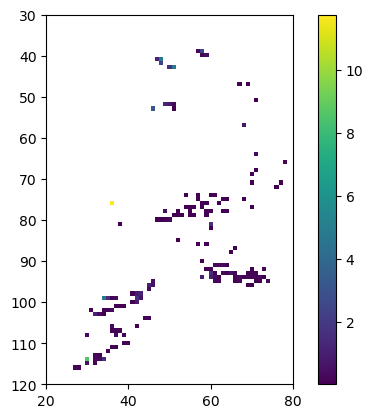

In [93]:
plt.imshow(np.nanmean(fr_ridge[tidx], axis = 0))
plt.xlim(20, 80)
plt.ylim(120, 30)
plt.colorbar()

In [ ]:
np.nanmean(data) - 0.6

0.13183508525597476

## Lead fractions

In [304]:
year = 2019

try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass

ncname = 'F:\\ATL03\\ATL07_test\\ncfile\\Grid_stats_{0}.nc'.format(year)
nc = netCDF4.Dataset(ncname, 'r')
keys = nc.variables.keys()

print(keys)

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mean_10', 'fb_mean_NN', 'fr_dl', 'fr_sl', 'fr_ow', 'fr_ti', 'fs_med_1', 'fs_med_2', 'fs_med_3', 'fs_med_4'])


In [305]:
## Define subregions based on lat/lon values
lat = np.array(nc.variables['lat'])
lon = np.array(nc.variables['lon'])
x = np.array(nc.variables['x'])
y = np.array(nc.variables['y'])
xx, yy = np.meshgrid(x, y)
np.shape(xx)

NW = (lat>-74) & (lat<-70) & ((lon<-172) | (lon>168))
SW = (lat>-78) & (lat<-74) & ((lon<-172) | (lon>168))
SE = (lat>-78) & (lat<-74) & ((lon<-150) & (lon>-172))
NE = (lat>-74) & (lat<-70) & ((lon<-150) & (lon>-172))

from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3031")

In [306]:
times = nc.variables['time']
times = num2date(times[:], units = times.units)

hours = np.array(nc.variables['time']).astype(float)
time_era = []

for i in range(0, len(hours)):
    time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))

In [307]:
offset = 0.5

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

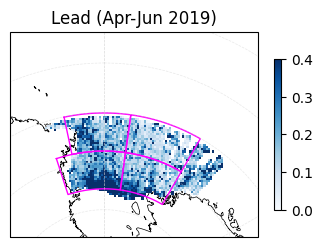

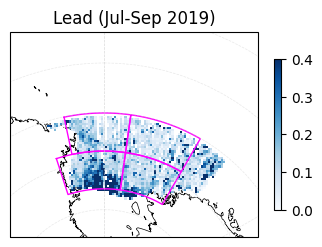

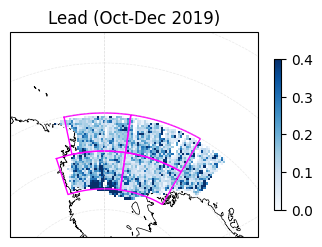

In [308]:
# Draw map ===========================================================

# date1 = [dt.datetime(year,3,1), dt.datetime(year,4,1), dt.datetime(year,5,1), dt.datetime(year,6,1),
#          dt.datetime(year,7,1), dt.datetime(year,8,1), dt.datetime(year,9,1), dt.datetime(year,10,1)]
# date2 = [dt.datetime(year,5,31), dt.datetime(year,6,30), dt.datetime(year,7,31), dt.datetime(year,8,31),
#          dt.datetime(year,9,30), dt.datetime(year,10,31), dt.datetime(year,11,30), dt.datetime(year,12,31)]

date1 = [dt.datetime(year,4,1), dt.datetime(year,7,1), dt.datetime(year,10,1)]
date2 = [dt.datetime(year,6,30), dt.datetime(year,9,30), dt.datetime(year,12,31)]


for i in range(0, len(date1)):
    
#     fig = plt.figure(figsize=(8,4), dpi= 100)
#     ax = plt.axes(projection=ccrs.SouthPolarStereo())

    fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})

    lons = np.arange(-180, -89)

    ax.coastlines('10m', linewidth = 0.5)
    
    ax.plot(NW_x, NW_y, lw=1, color = "magenta")
    ax.plot(NE_x, NE_y, lw=1, color = "magenta")
    ax.plot(SW_x, SW_y, lw=1, color = "magenta")
    ax.plot(SE_x, SE_y, lw=1, color = "magenta")

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')
    
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    
#     N = np.array(nc.variables['N'])
    
    tidx = (times >= date1[i]) & (times < date2[i])
    
    field1 = 'fr_ow'
    data1 = np.nanmean((np.array(nc.variables[field1]))[tidx, :, :], axis = 0).transpose()
    
    field2 = 'fr_ti'
    data2 = np.nanmean((np.array(nc.variables[field2]))[tidx, :, :], axis = 0).transpose()
    
#     'fb_mean', 'fb_median', 'fb_std', 'fb_hist_freq', 'fb_hist_val', 'fr_ridge', 'h_ridge_mean', 'fr_lead', 'N'
    
    vmin, vmax = {}, {};
    vmin['fb_mode'] = 0.0; vmax['fb_mode'] = 0.5
    vmin['fb_mode1'] = 0.0; vmax['fb_mode1'] = 0.5
    vmin['fb_mode2'] = 0.0; vmax['fb_mode2'] = 0.5
    vmin['fr_ridge'] = 0.0; vmax['fr_ridge'] = 10
    vmin['fb_mean'] = 0.0; vmax['fb_mean'] = 0.8
    vmin['fb_median'] = 0.0; vmax['fb_median'] = 0.8
    vmin['fb_std'] = 0.0; vmax['fb_std'] = 0.5
    vmin['fr_lead'] = 0.0; vmax['fr_lead'] = 0.02
    vmin['fr_ti'] = 0.0; vmax['fr_ti'] = 0.4
    vmin['h_ridge_mean'] = 0.6; vmax['h_ridge_mean'] = 1.0

    pm = ax.pcolormesh(xx, yy, data1+data2,
                          cmap = "Blues", vmin = vmin[field2], vmax = vmax[field2])

    xmin, xmax = ax.set_xlim(1100000, -1800000)
    ymin, ymax = ax.set_ylim(-800000, -3200000)
    
    ax.set_title("{0} ({1}-{2})".format("Lead", date1[i].strftime("%b"), date2[i].strftime("%b %Y")),
                   fontsize = 12)
    
    plt.colorbar(pm, ax = ax, shrink = 0.5)
    plt.savefig("F:\\2022_Ross\\Figures_map\\{0}_{1}-{2}.png".format(field2, date1[i].strftime("%Y%m"), date2[i].strftime("%Y%m")),
               bbox_inches="tight")
    
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass

## Time series

In [42]:
from scipy.interpolate import griddata

def snow_depth(fb, xx, yy, date, method = "KK"):
    # fb: freeboard (total snow freeboard; units in meters)
    if method == "KK": # Kacimi & Kwok, 2020 (ICESat-2, CryoSat-2)
        if date.month == 4:
            hs = fb*0.69 - 0.0397        
        elif date.month == 5:
            hs = fb*0.68 - 0.0372
        elif date.month == 6:
            hs = fb*0.69 - 0.0397
        elif date.month == 7:
            hs = fb*0.69 - 0.0397
        elif date.month == 8:
            hs = fb*0.69 - 0.0410            
        elif date.month == 9:
            hs = fb*0.66 - 0.0420
        elif date.month == 10:
            hs = fb*0.66 - 0.0420 
        else:          
            hs = fb*0.66 - 0.0345            
            
    elif method == "AMSR": # Snow depth from AMSR data
        hs = read_AMSR(date, xx, yy)
        
    elif method == "zero": # Zero ice freeboard
        hs = fb
        
    elif method == "XOC": # Ozsoy-Cicek et al., 2013 (Empirical equation)
        hs = 1.05*fb - 0.005
            
    return hs

def ice_thickness(fb, hs):
    pw = 1024
    ps = 340
    pi = 917
    hi = (pw/(pw-pi))*fb + ((ps-pw)/(pw-pi))*hs
    return hi

def read_AMSR(date, xx, yy):

    h5file = "D:\\Ross\\AMSR\\AMSR_U2_L3_SeaIce12km_B04_{0}.he5".format(dt.datetime.strftime(date, "%Y%m%d"))
    
    with h5py.File(h5file) as f:
        lat2 = f['HDFEOS']['GRIDS']['SpPolarGrid12km']['lat'][:]
        lon2 = f['HDFEOS']['GRIDS']['SpPolarGrid12km']['lon'][:]
        sd = f['HDFEOS/GRIDS/SpPolarGrid12km/Data Fields/SI_12km_SH_SNOWDEPTH_5DAY'][:] * 0.01  # cm to m
        
        sd[sd > 0.7] = np.nan

        # EPSG:4326 (WGS84); EPSG:3408 (NSIDC EASE-Grid North - Polar pathfinder sea ice movement)
        inProj = Proj('epsg:4326')  
        outProj = Proj('epsg:3412')
        xx2,yy2 = transform(inProj,outProj,lat2,lon2)
        grid_sd = griddata((xx2.flatten(), yy2.flatten()), sd.flatten(), (xx, yy), method='nearest')
    
    return grid_sd 

In [ ]:
try: nc.close()  # just to be safe, make sure dataset is not already open.
except: pass

for year in [2018, 2019, 2020, 2021, 2022]:
    
    ncname = f'D:\\Ross\\ATL10_processed_nc\\Ridges_density_{year}.nc'
    ds = xr.open_dataset(ncname)
    
    with netCDF4.Dataset(ncname, 'r') as nc:
        x = nc.variables['x']
        y = nc.variables['y']
        xx, yy = np.meshgrid(x, y)
        times = nc.variables['time']
        times = num2date(times[:], units = times.units)
        hours = np.array(nc.variables['time']).astype(float)
        time_era = []

    for i in range(0, len(hours)):
        time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))

    df = pd.DataFrame()
    df['date'] = time_era

    win = 10

    for region in ["NW", "SW", "NE", "SE"]:
        
        print(year, region)

        if region == "NW":
            roi = NW
        elif region == "SW":
            roi = SW
        elif region == "NE":
            roi = NE
        elif region == "SE":
            roi = SE

        fields = ["fb_mean", "fb_med", "fb_mode", "fr_ridge", "fb_std", "h_ridge"]
        snow_methods = ["KK", "AMSR", "zero", "XOC"]

        for i in tqdm(range(0, len(times))):
            for field in fields:
                df.loc[i, field] = np.nanmedian((np.array(ds.variables[field]))[i, :, :].transpose()[roi])
            fb_mean = (np.array(ds.variables["fb_mean"]))[i, :, :].transpose()
            fb_med = (np.array(ds.variables["fb_med"]))[i, :, :].transpose()
            fb_mode = (np.array(ds.variables["fb_mode"]))[i, :, :].transpose()
            for snow_method in snow_methods:
                hs = snow_depth(fb_mode, xx, yy, time_era[i], method = snow_method)
                hi = ice_thickness(fb_mode, hs)
                df.loc[i, "hs_" + snow_method] = np.nanmedian(hs[roi])
                df.loc[i, "thk_" + snow_method] = np.nanmedian(hi[roi])                
        
        for snow_method in snow_methods:
            fields.append("hs_" + snow_method)
            fields.append("thk_" + snow_method)
        
        for field in fields:
            for i in range(0, len(df['date'])):
                date = df['date'][i]
                d = np.exp(
                    -(((df['date'] - date).apply(lambda x: x.days)) ** 2) / (2 * (win ** 2))
                )        

                value = np.sum(df[field] * d) / np.nansum(d)
                df.loc[i, field+"_sm"] = value
        
        df.to_csv("D:\\Ross\\Time_series\\TS_{0}_{1}_win{2}.csv".format(year, region, win))
        
try: nc.close()  # just to be safe, make sure dataset is not already open.
except: pass

print("DONE!")

In [448]:
ds.variables['fb_count'].max()


<xarray.Variable ()>
array(28195.)

#### Calculate monthly mean from daily data

In [68]:
## MONTHLY MEAN

try: nc.close()  # just to be safe, make sure dataset is not already open.
except: pass

for year in [2022]:
    
    ncname = f'D:\\Ross\\ATL10_processed_nc\\Ridges_density_{year}.nc'
    ds = xr.open_dataset(ncname)
    
    months = np.unique(ds.time.dt.month)
    
    with netCDF4.Dataset(ncname, 'r') as nc:
        x = nc.variables['x']
        y = nc.variables['y']
        xx, yy = np.meshgrid(x, y)
        times = nc.variables['time']
        times = num2date(times[:], units = times.units)
        hours = np.array(nc.variables['time']).astype(float)
        time_era = []
        time_month = []
        
    for i in range(0, len(hours)):
        time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))

    for m in months:
        time_month.append(dt.datetime(year, m, 14))
        
#     for i in range(0, len(time_era)):
#         date = time_era[i]
#         d = np.exp(
#             -(((time_era - date).apply(lambda x: x.days)) ** 2) / (2 * (win ** 2))
#         )        
        
#         value = np.sum(df[field] * d) / np.nansum(d)
#         df.loc[i, field+"_sm"] = value

    for region in ["SE", "NW", "NE", "SW"]:
        
        df = pd.DataFrame()
        df['date'] = time_month
        
        print(year, region)

        if region == "NW":
            roi = NW
        elif region == "SW":
            roi = SW
        elif region == "NE":
            roi = NE
        elif region == "SE":
            roi = SE

        fields = ["fb_mean", "fb_med", "fb_mode", "fr_ridge", "fb_std", "h_ridge"]
        snow_methods = ["KK"] #, "AMSR", "zero", "XOC"]

        for j, m in tqdm(enumerate(months)):
            df.loc[j, 'year'] = int(year)
            df.loc[j, 'month'] = int(m)
            
            idx = np.where(ds.time.dt.month == m)[0]
            
            fb_count = np.nansum(np.transpose(np.array(ds.variables["fb_count"][idx, :, :]), axes = (0, 2, 1)), axis = 0)
            fb_mean = np.transpose(np.array(ds.variables['fb_mean'][idx, :, :]), axes = (0, 2, 1))
            fb_med = np.transpose(np.array(ds.variables['fb_med'][idx, :, :]), axes = (0, 2, 1))
            fb_mode = np.transpose(np.array(ds.variables['fb_mode'][idx, :, :]), axes = (0, 2, 1))
            h_ridge = np.transpose(np.array(ds.variables['h_ridge'][idx, :, :]), axes = (0, 2, 1))
            if year == 2022: # and (region == "SE" or region == "NE"):
                if m == 4:
                    valid_ridge = (h_ridge < 0.85)
                else:
                    valid_ridge = (h_ridge < 1.0)
            else:
                valid_ridge = (h_ridge >= 0.6)
            
            valid_count = (fb_count > 200)
            
            for field in fields:
                array = np.transpose(np.array(ds.variables[field][idx, :, :]), axes = (0, 2, 1))
                if field in ["fr_ridge", "h_ridge"]:
                    array[~valid_ridge] = np.nan
                df.loc[j, field] = np.nanmedian(np.nanmedian(array, axis = 0)[roi & valid_count])
                df.loc[j, field + "_unc"] = np.nanstd(np.nanmedian(array, axis = 0)[roi & valid_count])
                df.loc[j, field + "_q25"] = np.nanquantile(np.nanmedian(array, axis = 0)[roi & valid_count], 0.25)
                df.loc[j, field + "_q75"] = np.nanquantile(np.nanmedian(array, axis = 0)[roi & valid_count], 0.75)
            
            hs = np.zeros(fb_mean.shape)
            hi = np.zeros(fb_mean.shape)
            for snow_method in snow_methods:
                for i, k in enumerate(idx):
                    hs[i] = snow_depth(fb_mode[i], xx, yy, time_era[k], method = snow_method)
                    hi[i] = ice_thickness(fb_mode[i], hs[i])
                df.loc[j, "hs_" + snow_method] = np.nanmedian(np.nanmedian(hs, axis = 0)[roi & valid_count])
                df.loc[j, "hi_" + snow_method] = np.nanmedian(np.nanmedian(hi, axis = 0)[roi & valid_count]) 
                df.loc[j, "hi_" + snow_method + "_unc"] = np.nanstd(np.nanmedian(hi, axis = 0)[roi & valid_count])
                df.loc[j, "hi_" + snow_method + "_q25"] = np.nanquantile(np.nanmedian(hi, axis = 0)[roi & valid_count], 0.25)
                df.loc[j, "hi_" + snow_method + "_q75"] = np.nanquantile(np.nanmedian(hi, axis = 0)[roi & valid_count], 0.75)
        
        df.to_csv("D:\\Ross\\Time_series\\Monthly_{0}_{1}.csv".format(year, region))
        
try: nc.close()  # just to be safe, make sure dataset is not already open.
except: pass

print("DONE!")

2022 SE


12it [00:12,  1.02s/it]


2022 NW


12it [00:11,  1.07it/s]


2022 NE


12it [00:11,  1.01it/s]


2022 SW


12it [00:11,  1.00it/s]

DONE!


In [69]:
fields = ["fb_mean", "fb_med", "fb_mode", "fr_ridge", "fb_std", "h_ridge"]
snow_methods = ["KK"] #, "AMSR", "zero", "XOC"]              

for snow_method in snow_methods:
    fields.append("hs_" + snow_method)
    fields.append("hi_" + snow_method)

win = 10
for region in ["NW", "SW", "NE", "SE"]:
    first = True
    for year in [2018, 2019, 2020, 2021, 2022]:
        df0 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_{0}_{1}.csv".format(year, region), index_col = 0)
        df0['date'] = pd.to_datetime(df0['date'])
        
        if first:
            df1 = df0
            first = False
        else:
            df1 = pd.concat([df1, df0]).reset_index(drop = True)
            
    df1.to_csv("D:\\Ross\\Time_series\\Monthly_total_{0}_withunc.csv".format(region))
    print(region)
print("DONE!")

NW
SW
NE
SE
DONE!


In [29]:
date_ticks = []
date_labels = []
for y in [2018, 2019, 2020, 2021, 2022]:
    for m in [1, 4, 7, 10]:
        
        if y == 2018:
            if m == 10:
                date_ticks.append(dt.datetime(y, m, 1))
                date_labels.append(dt.datetime(y, m, 1).strftime("%b"))
        else:
            date_ticks.append(dt.datetime(y, m, 1))
            if m == 1:
                date_labels.append(dt.datetime(y, m, 1).strftime("%b\n%Y"))
            else:
                date_labels.append(dt.datetime(y, m, 1).strftime("%b"))

Text(0, 0.5, 'Modal SIT (m)')

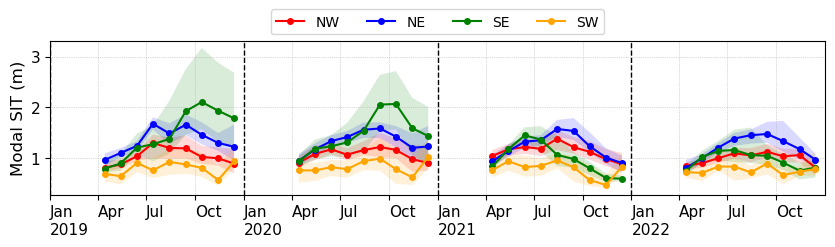

In [82]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
roi_name = ["NW", "NE", "SE", "SW"]


field = "hi_KK"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}_withunc.csv".format(region))
    df1.loc[df1['month']<=3, field] = np.nan
    df1.loc[df1['month']<=3, field + "_q25"] = np.nan
    df1.loc[df1['month']<=3, field + "_q75"] = np.nan
    
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])
    plt.fill_between(df_month['date'], df_month[field + "_q75"], df_month[field + "_q25"],
                     color = colors[i], alpha = 0.15, linewidth = 0)
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
# plt.yscale('log')
plt.xlim(dt.datetime(2019, 1, 1), dt.datetime(2023,1,1))
plt.ylabel("Modal SIT (m)", fontsize = 12)

In [58]:
df_

Index(['date_str', 'Unnamed: 0', 'date', 'year', 'month', 'fb_mean', 'fb_med',
       'fb_mode', 'fr_ridge', 'fb_std', 'h_ridge', 'hs_KK', 'hi_KK', 'hs_AMSR',
       'hi_AMSR', 'hs_zero', 'hi_zero', 'hs_XOC', 'hi_XOC', 'date_num'],
      dtype='object')

Text(0, 0.5, 'Ridge fraction (%)')

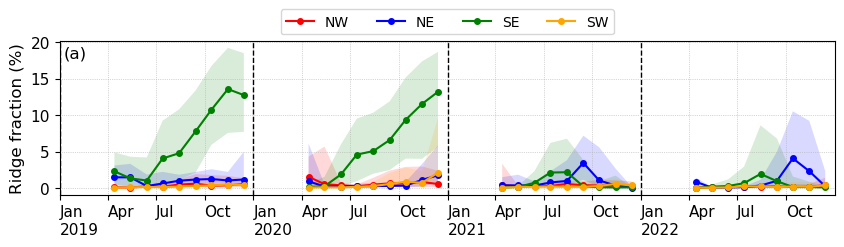

In [70]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
roi_name = ["NW", "NE", "SE", "SW"]

field = "fr_ridge"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}_withunc.csv".format(region))
    df1.loc[df1['month']<=3, field] = np.nan
    df1.loc[df1['month']<=3, field + "_q25"] = np.nan
    df1.loc[df1['month']<=3, field + "_q75"] = np.nan
    
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])
    plt.fill_between(df_month['date'], df_month[field + "_q75"], df_month[field + "_q25"],
                     color = colors[i], alpha = 0.15, linewidth = 0)
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.annotate("(a)", xy=(0.005, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
# plt.yscale('log')
# plt.ylim(0.6, 1)
plt.xlim(dt.datetime(2019, 1, 1), dt.datetime(2023,1,1))
plt.ylabel("Ridge fraction (%)", fontsize = 12)

Text(0, 0.5, 'Ridge height (m)')

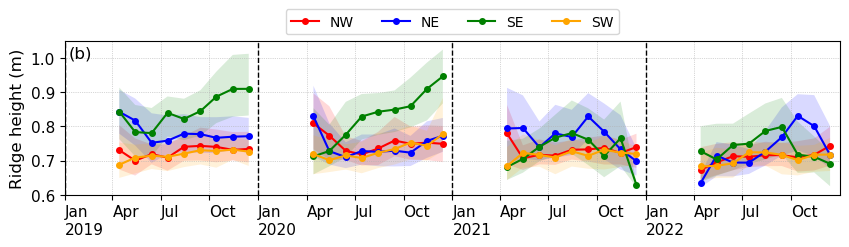

In [84]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
roi_name = ["NW", "NE", "SE", "SW"]

field = "h_ridge"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}_withunc.csv".format(region))
    df1.loc[df1['month']<=3, field] = np.nan
    df1.loc[df1['month']<=3, field + "_q25"] = np.nan
    df1.loc[df1['month']<=3, field + "_q75"] = np.nan
    
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])
    plt.fill_between(df_month['date'], df_month[field + "_q75"], df_month[field + "_q25"],
                     color = colors[i], alpha = 0.15, linewidth = 0)
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.annotate("(b)", xy=(0.005, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
# plt.yscale('log')
plt.ylim(0.60, 1.05)
plt.xlim(dt.datetime(2019, 1, 1), dt.datetime(2023,1,1))
plt.ylabel("Ridge height (m)", fontsize = 12)

In [ ]:
df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}.csv".format("SE"))
df1.loc[df1['month']<=3, field] = np.nan
    
df1['date'] = pd.to_datetime(df1['date'])

df1['date'] = pd.to_datetime(df1['date'])
df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
df1['date_str'] = df1['date_num'].astype(str)
df_month = df1.groupby('date_str', as_index = False).mean()
df_month['date'] = pd.to_datetime(df_month['date_str'])

df_month

Text(0, 0.5, 'Surface\nroughness (m)')

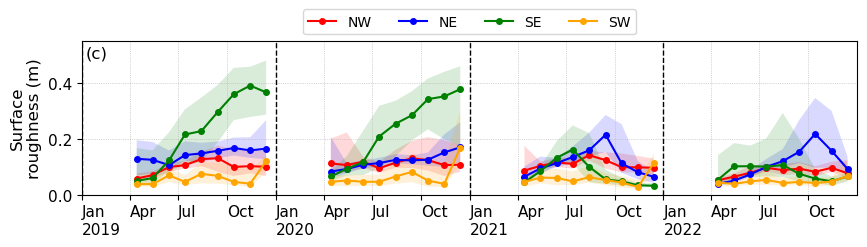

In [83]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
roi_name = ["NW", "NE", "SE", "SW"]

field = "fb_std"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}_withunc.csv".format(region))
    df1.loc[df1['month']<=3, field] = np.nan
    df1.loc[df1['month']<=3, field + "_q25"] = np.nan
    df1.loc[df1['month']<=3, field + "_q75"] = np.nan
    
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])
    plt.fill_between(df_month['date'], df_month[field + "_q75"], df_month[field + "_q25"],
                     color = colors[i], alpha = 0.15, linewidth = 0)
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.annotate("(c)", xy=(0.005, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
# plt.yscale('log')
plt.ylim(0.0,0.55)
plt.xlim(dt.datetime(2019, 1, 1), dt.datetime(2023,1,1))
plt.ylabel("Surface\nroughness (m)", fontsize = 12)

Text(0, 0.5, 'Modal SIT (m)')

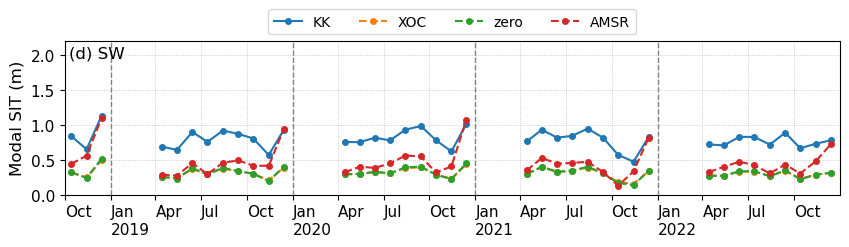

In [594]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
lss = ["-", "--", "--", "--"]
markers = ["o", "o", "o", "o"]
roi_name = ["NW", "NE", "SE", "SW"]

snow_methods = ["KK", "XOC", "zero", "AMSR"]

region = "SW"
orders = {'NW': '(a)', 'NE': '(b)', 'SE': '(c)', 'SW': '(d)'}
for i, method in enumerate(snow_methods):
    field = f"hi_{method}"
    df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}.csv".format(region))
    df1.loc[df1['month']<=3, field] = np.nan
    
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = markers[i], ls = lss[i], ms = 4, label = method)
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'gray', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.annotate(f"{orders[region]} {region}", xy=(0.005, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
# plt.yscale('log')
plt.ylim(0.0, 2.2)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Modal SIT (m)", fontsize = 12)

Text(0, 0.5, 'Snow depth (m)')

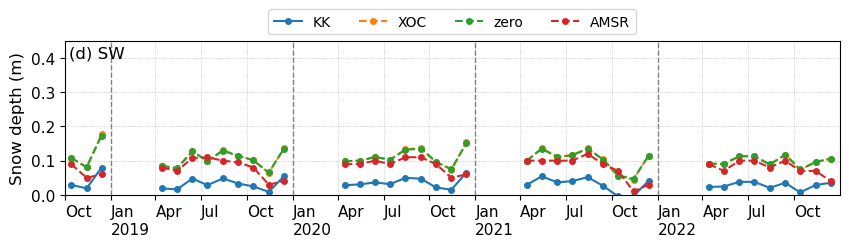

In [637]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
lss = ["-", "--", "--", "--"]
markers = ["o", "o", "o", "o"]
roi_name = ["NW", "NE", "SE", "SW"]

snow_methods = ["KK", "XOC", "zero", "AMSR"]

region = "SW"
orders = {'NW': '(a)', 'NE': '(b)', 'SE': '(c)', 'SW': '(d)'}
for i, method in enumerate(snow_methods):
    field = f"hs_{method}"
    df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}.csv".format(region))
    df1.loc[df1['month']<=3, field] = np.nan
    
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = markers[i], ls = lss[i], ms = 4, label = method)
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'gray', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.annotate(f"{orders[region]} {region}", xy=(0.005, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
# plt.yscale('log')
plt.ylim(0.0, 0.45)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Snow depth (m)", fontsize = 12)

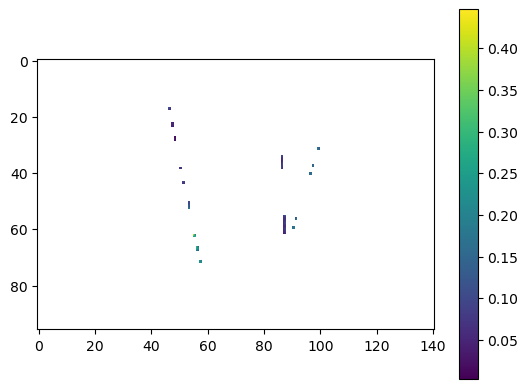

In [323]:
plt.imshow(hs)
plt.colorbar()

In [292]:
fields = ["fb_mean", "fb_med", "fb_mode", "fr_ridge", "fb_std", "h_ridge"]
snow_methods = ["KK", "AMSR", "zero", "XOC"]              

for snow_method in snow_methods:
    fields.append("hs_" + snow_method)
    fields.append("thk_" + snow_method)

win = 10
for region in ["NW", "SW", "NE", "SE"]:
    first = True
    for year in [2018, 2019, 2020, 2021, 2022]:
        df0 = pd.read_csv("D:\\Ross\\Time_series\\TS_{0}_{1}_win10.csv".format(year, region), index_col = 0)
        df0['date'] = pd.to_datetime(df0['date'])
        
        if first:
            df1 = df0
            first = False
        else:
            df1 = df1.append(df0).reset_index(drop = True)
            
    for field in fields:
        for i in range(0, len(df1['date'])):
            date = df1['date'][i]
            d = np.exp(
                -(((df1['date'] - date).apply(lambda x: x.days)) ** 2) / (2 * (win ** 2))
            )        

            value = np.sum(df1[field] * d) / np.nansum(d)
            df0.loc[i, field+"_sm"] = value
            
    df1.to_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    print(region)
print("DONE!")

NW
SW
NE
SE
DONE!


In [197]:
df1

,Unnamed: 0,date,fb_mean,fb_med,fb_mode,fr_ridge,fb_std,h_ridge,fb_mean_sm,fb_med_sm,fb_mode_sm,fr_ridge_sm,fb_std_sm,h_ridge_sm,date_num,date_str
0,0,2018-10-14,0.069711,0.066864,0.066261,0.000000,0.034026,0.652772,0.148123,0.130759,0.123564,0.485996,0.084594,0.549148,20181014,20181014
1,1,2018-10-15,0.134726,0.117081,0.116247,0.021191,0.073185,0.686173,0.148379,0.131014,0.123599,0.500548,0.084845,0.546143,20181014,20181014
2,2,2018-10-16,0.180091,0.165307,0.159714,0.283286,0.104693,0.711896,0.148538,0.131194,0.123544,0.515777,0.085062,0.542891,20181014,20181014
3,3,2018-10-17,0.305401,0.263261,0.242081,2.009621,0.195529,0.778627,0.148588,0.131289,0.123392,0.531584,0.085240,0.539381,20181014,20181014
4,4,2018-10-18,NaN,NaN,NaN,NaN,NaN,NaN,0.148518,0.131290,0.123133,0.547841,0.085374,0.535607,20181014,20181014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,1436,2022-12-27,0.093102,0.066840,0.072238,0.070366,0.087780,0.681971,0.090752,0.082690,0.080464,0.073657,0.055890,0.350531,20221214,20221214
1437,1437,2022-12-28,0.117164,0.100728,0.092071,0.000000,0.082872,0.636656,0.090900,0.082711,0.080654,0.071852,0.055948,0.355552,20221214,20221214
1438,1438,2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,0.091114,0.082801,0.080903,0.070399,0.056045,0.360461,20221214,20221214
1439,1439,2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,0.091389,0.082955,0.081205,0.069300,0.056180,0.365226,20221214,20221214


### Daily comparison

Text(0, 0.5, 'Modal Freeboard (m)')

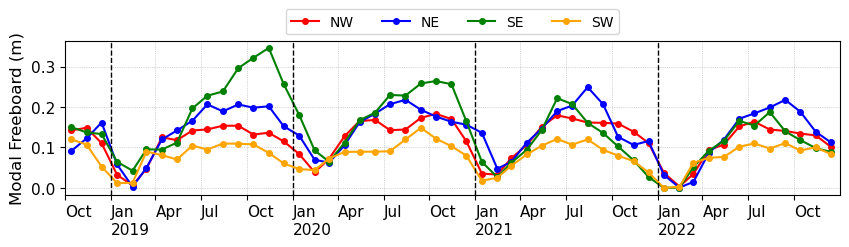

In [321]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
roi_name = ["NW", "NE", "SE", "SW"]


field = "fb_mode_sm"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Modal Freeboard (m)", fontsize = 12)

Text(0, 0.5, 'Snow depth (m)')

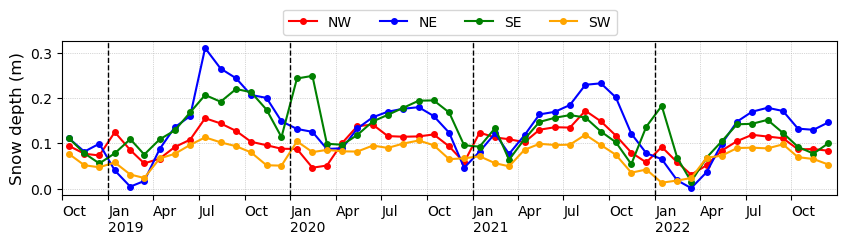

In [319]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
roi_name = ["NW", "NE", "SE", "SW"]


field = "hs_AMSR_sm"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 10, ha = "left")
plt.yticks(fontsize = 10)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Snow depth (m)", fontsize = 12)

Text(0, 0.5, 'Ice thickness (m)')

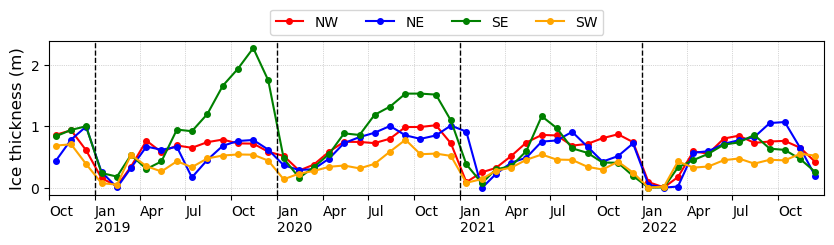

In [320]:
plt.figure(figsize = (10,2), dpi = 100)

colors = ["red", "blue", "green", "orange"]
roi_name = ["NW", "NE", "SE", "SW"]

field = "thk_AMSR_sm"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])
#     plt.plot(df1['date'], df1[field], label = region)

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)
# plt.axvline(dt.datetime(2021, 1, 1), color = 'k', ls = "--", lw = 1.0)
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 10, ha = "left")
plt.yticks(fontsize = 10)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Ice thickness (m)", fontsize = 12)

Text(0, 0.5, 'Ridge fraction (%)')

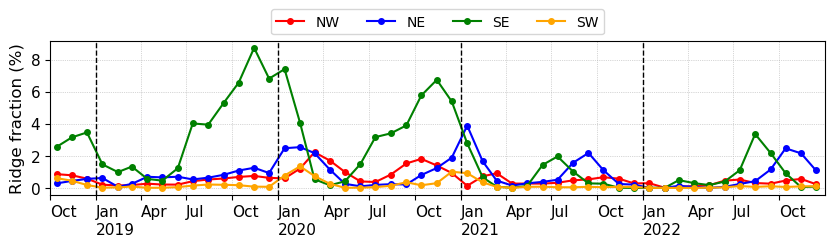

In [190]:
plt.figure(figsize = (10,2), dpi = 100)

field = "fr_ridge_sm"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)

plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Ridge fraction (%)", fontsize = 12)

Text(0, 0.5, 'Mean - mode (m)')

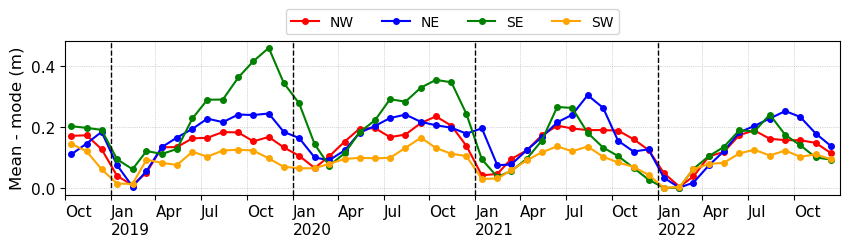

In [192]:
plt.figure(figsize = (10,2), dpi = 100)

field = "fb_mean_sm"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)

plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Mean - mode (m)", fontsize = 12)

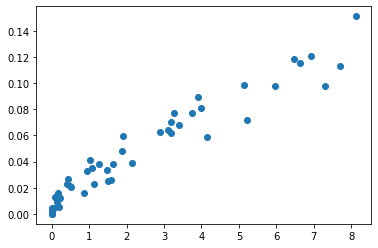

In [348]:
plt.scatter(df_month['fr_ridge_sm'], df_month['fb_mean_sm'] - df_month['fb_mode_sm'])

Text(0, 0.5, 'Ridge height (m)')

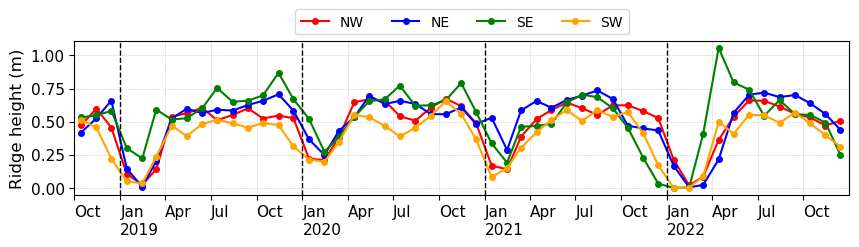

In [194]:
plt.figure(figsize = (10,2), dpi = 100)

field = "h_ridge_sm"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)

plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Ridge height (m)", fontsize = 12)

Text(0, 0.5, 'Std. Freeboard (m)')

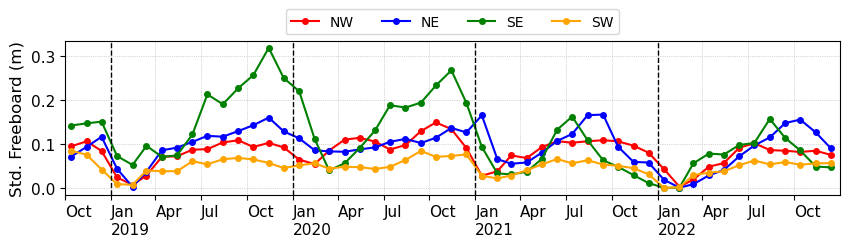

In [195]:
plt.figure(figsize = (10,2), dpi = 100)

field = "fb_std_sm"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)

plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Std. Freeboard (m)", fontsize = 12)

Text(0, 0.5, 'Ridge height (m)')

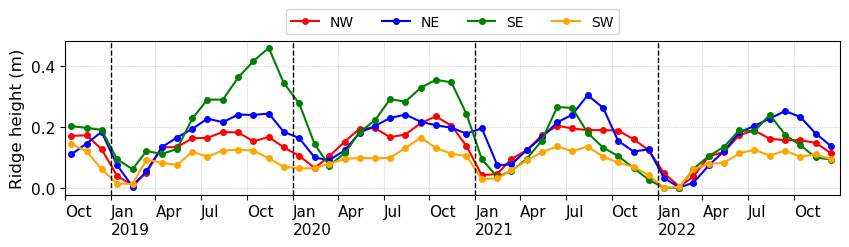

In [196]:
plt.figure(figsize = (10,2), dpi = 100)

field = "fb_mean_sm"
for i, region in enumerate(roi_name):
    df1 = pd.read_csv("D:\\Ross\\Time_series\\TS_total_{0}.csv".format(region))
    df1['date'] = pd.to_datetime(df1['date'])
    
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month = df1.groupby('date_str', as_index = False).mean()
    df_month['date'] = pd.to_datetime(df_month['date_str'])
    
    plt.plot(df_month['date'], (df_month[field]), marker = 'o', ms = 4, label = region, color = colors[i])

for year in [2018, 2019, 2020, 2021, 2022]:
    plt.axvline(dt.datetime(year, 1, 1), color = 'k', ls = "--", lw = 1.0)

plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol = 4)
plt.grid(ls = ":", lw = 0.5)
plt.xticks(date_ticks, date_labels, fontsize = 11, ha = "left")
plt.yticks(fontsize = 11)
plt.xlim(dt.datetime(2018, 10, 1), dt.datetime(2023,1,1))
plt.ylabel("Ridge height (m)", fontsize = 12)

## Comparison with ERA5

In [113]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

def conditional_count(df, field, vmin, vmax):
    # Count the number of data satifying the min/max value conditions
    array = df[field].values
    count = len(np.where((array >= vmin) & (array <= vmax))[0])
    return count

roi_name = ["NW", "NE", "SE", "SW"]

data = {}

for i in range(0, len(roi_name)):
    first = True
    for year in [2019, 2020, 2021, 2022]:
        for month in np.arange(1, 13):
            df0 = pd.read_csv("D:\\Ross\\ERA5\\TS_MERRA_{0}_{1}_{2}.csv".format(roi_name[i], year, month), index_col=0)
            df0['date'] = pd.to_datetime(df0['date'])
            df0['wind'] = (df0["U2M"]**2+df0["V2M"]**2)**0.5
            df0['year'] = df0['date'].dt.year
            df0['month'] = df0['date'].dt.month
            df0['day'] = 14 #df0['date'].dt.day
            df0['date_num'] = df0['year']*10000 + df0['month']*100 + df0['day']
            df0['month_num'] = df0['year']*10000 + df0['month']*100 + df0['day']
            df0['date_str'] = df0['date_num'].astype(str)
            df0['month_str'] = df0['month_num'].astype(str)
            if first:
                df_data = df0
                first = False
            else:
                df_data = pd.concat([df_data, df0]).reset_index(drop=True) #df_data.append(df0).reset_index(drop=True)
    data[roi_name[i]] = df_data
print("DONE!")

DONE!


In [115]:
from scipy import stats

NW PearsonRResult(statistic=0.5613932428403953, pvalue=0.004312100389558058)
NE PearsonRResult(statistic=0.8037011596276851, pvalue=2.244698045006166e-06)
SE PearsonRResult(statistic=0.4610928349293378, pvalue=0.02334229354119008)
SW PearsonRResult(statistic=0.48123680216973197, pvalue=0.0172754954355063)


Text(0, 0.5, 'Modal SIT (m)')

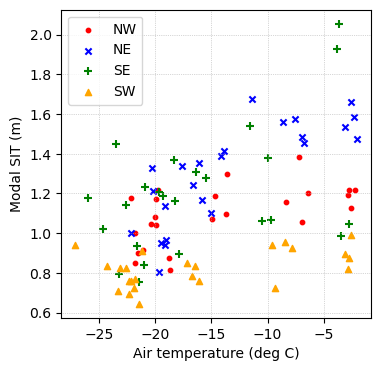

In [116]:
plt.figure(figsize = (4,4), dpi = 100)
markers = ["o", "x", "+", "^"]
sizes = [10, 20, 40, 20]
for i, region in enumerate(roi_name):
    
    df_data = data[region]
    df_month = df_data.groupby(by = "month_num", as_index = False).mean()
    df_month['date_str'] = df_month['month_num'].astype(str)
    # df_month['datetime_mon'] = pd.to_datetime(df_month['month_str'], format = "%Y%m%d")
    # df_month.head()
    
    df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}.csv".format(region), index_col = 0)
    df1.loc[df1['month']<=3, field] = np.nan

    df1['date'] = pd.to_datetime(df1['date'])
    df1['date'] = pd.to_datetime(df1['date'])
    df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
    df1['date_str'] = df1['date_num'].astype(str)
    df_month0 = df1.groupby('date_str', as_index = False).mean()
    df_month0.head()
    
    df_all = df_month.join(df_month0, lsuffix='', rsuffix='_other').dropna()
    df_all = df_all[(df_all['month'] >= 4)].reset_index(drop=True)
    print(region, stats.pearsonr(df_all['T2M'].values, df_all['hi_KK'].values))
    
    plt.scatter(df_all['T2M'].values-273.15, df_all['hi_KK'].values, color = colors[i], label = region, marker = markers[i], s=sizes[i])
    
plt.legend()
plt.grid(ls = ":", lw = 0.5)
plt.xlabel("Air temperature (deg C)")
plt.ylabel("Modal SIT (m)")

In [718]:
df1 = pd.read_csv("D:\\Ross\\Time_series\\Monthly_total_{0}.csv".format(region), index_col = 0)
df1.loc[df1['month']<=3, field] = np.nan

df1['date'] = pd.to_datetime(df1['date'])

df1['date'] = pd.to_datetime(df1['date'])
df1['date_num'] = df1['date'].dt.year*10000 + df1['date'].dt.month*100 + 14
df1['date_str'] = df1['date_num'].astype(str)
df_month0 = df1.groupby('date_str', as_index = False).mean()
df_month0.head()

,date_str,year,month,fb_mean,fb_med,fb_mode,fr_ridge,fb_std,h_ridge,hs_KK,hi_KK,hs_AMSR,hi_AMSR,hs_zero,hi_zero,hs_XOC,hi_XOC,date_num
0,20181014,2018.0,10.0,0.317663,0.241545,0.210081,5.849335,0.248478,0.838024,0.096654,1.374571,0.13,1.039335,0.210081,0.628281,0.215585,0.592067,20181014.0
1,20181114,2018.0,11.0,0.233283,0.188396,0.161873,6.729560,0.178264,0.833369,0.072336,1.073206,0.08,1.018687,0.161873,0.484105,0.164966,0.463751,20181114.0
2,20181214,2018.0,12.0,0.291316,0.235350,0.199940,6.244712,0.226817,0.847259,0.097461,1.272212,0.05,1.449449,0.199940,0.597953,0.204937,0.565075,20181214.0
3,20190114,2019.0,1.0,0.317537,0.233429,0.185037,6.475159,0.264367,NaN,0.087624,1.194302,0.06,1.007341,0.185037,0.553382,0.189289,0.525407,20190114.0
4,20190214,2019.0,2.0,0.280877,0.153503,0.108332,6.980612,0.288229,NaN,0.036999,0.793312,0.11,0.422620,0.108332,0.323982,0.108748,0.321242,20190214.0


In [724]:
np.corrcoef(df_all['hi_KK'].values, df_all['T2M'].values)

array([[1.        , 0.46325902],
       [0.46325902, 1.        ]])

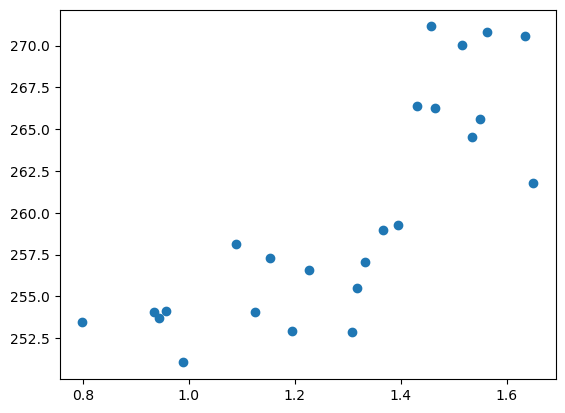

In [728]:
plt.scatter(df_all['hi_KK'].values, df_all['T2M'].values)

## Weather data (ERA5)

In [207]:
## Import daily ERA5 from Google Earth Engine
import ee
import geemap
ee.Initialize()



In [130]:
NW = ee.Geometry.Rectangle([168, -74, -172, -70]);
SW = ee.Geometry.Rectangle([168, -78, -172, -74]);
NE = ee.Geometry.Rectangle([-172, -74, -150, -70]);
SE = ee.Geometry.Rectangle([-172, -78, -150, -74]);

roi_list = [NW, SW, NE, SE]
roi_name = ["NW", "SW", "NE", "SE"]

for year in [2018, 2019, 2020, 2021, 2022]:
    for month in np.arange(1, 13):
        print(year, month)
        
        date1 = "{0}-{1}-01".format(year, month)
        if month == 12:
            date2 = "{0}-01-01".format(year+1)
        else:
            date2 = "{0}-{1}-01".format(year, month+1)
        
        for i in range(0, len(roi_list)):
            roi = roi_list[i]
            first = True
            for field in ["U2M", "V2M", "PS", "T2M"]:
                def temp_series(img):
                    mean = img.reduceRegion(reducer=ee.Reducer.max(), geometry=roi, scale=50000).get(field)
                    return img.set('date', img.date().format()).set(field,mean)

                imcol = ee.ImageCollection("NASA/GSFC/MERRA/slv/2").filterDate(date1, date2).select(field)
                reduced_imgs = imcol.map(temp_series)

                data_list = reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date', field]).values().get(0)
                df = pd.DataFrame(data_list.getInfo(), columns=['date', field])
                df['date'] = pd.to_datetime(df['date'])

                if first:
                    df2 = df
                    first = False
                else:
                    df2[field] = df[field]

            df2.to_csv("F:\\2022_Ross\\ERA5\\TS_MERRA_max_{0}_{1}_{2}.csv".format(roi_name[i], year, month))
        


# u10 = ee.ImageCollection("NASA/GSFC/MERRA/slv/2").filterDate("2019-10-01", "2019-11-01").select("PS") #.mean()
# # v10 = ee.ImageCollection("ECMWF/ERA5/DAILY").filterDate("2019-10-01").select("v_component_of_wind_10m")
# # u = u10.reduceRegion(reducer=ee.Reducer.mean(), geometry=NW, scale=50000).get("U2M").getInfo()

# reduced_imgs = u10.map(temp_u10, field = "PS", roi = NW)
# data_list = reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','value']).values().get(0)
# df = pd.DataFrame(data_list.getInfo(), columns=['date', 'value'])
# df['date'] = pd.to_datetime(df['date'])

2018 1
2018 2
2018 3
2018 4
2018 5
2018 6
2018 7
2018 8
2018 9
2018 10
2018 11
2018 12
2019 1
2019 2
2019 3
2019 4
2019 5
2019 6
2019 7
2019 8
2019 9
2019 10
2019 11
2019 12
2020 1
2020 2
2020 3
2020 4
2020 5
2020 6
2020 7
2020 8
2020 9
2020 10
2020 11
2020 12
2021 1
2021 2
2021 3
2021 4
2021 5
2021 6
2021 7
2021 8
2021 9
2021 10
2021 11
2021 12
2022 1
2022 2
2022 3
2022 4
2022 5
2022 6
2022 7
2022 8
2022 9
2022 10
2022 11
2022 12


## Draw maps of ERA5

In [36]:
try: nc.close()  # just to be safe, make sure dataset is not already open.
except: pass
    
ncname = 'F:\\2022_Ross\\ERA5\\ERA5_2018-2022.nc'
nc = netCDF4.Dataset(ncname, 'r')
keys = nc.variables.keys()

print(keys)

times = nc.variables['time']
times = num2date(times[:], units = times.units)

hours = np.array(nc.variables['time']).astype(float)
time_era = []

for i in range(0, len(hours)):
    time_era.append(dt.datetime(1900, 1, 1) + dt.timedelta(hours = hours[i]))

df = pd.DataFrame()
df['date'] = time_era

lat0 = np.array(nc.variables['latitude'])
lon0 = np.array(nc.variables['longitude'])

lon = np.meshgrid(lon0, lat0)[0]
lat = np.meshgrid(lon0, lat0)[1]

xx, yy = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), lat, lon) 

NW = (lat>-74) & (lat<-70) & ((lon<-172) | (lon>168))
SW = (lat>-78) & (lat<-74) & ((lon<-172) | (lon>168))
SE = (lat>-78) & (lat<-74) & ((lon<-150) & (lon>-172))
NE = (lat>-74) & (lat<-70) & ((lon<-150) & (lon>-172))

u10 = np.array(nc.variables['u10'])
v10 = np.array(nc.variables['v10'])
wind = (u10**2 + v10**2)**0.5

dict_keys(['longitude', 'latitude', 'expver', 'time', 'u10', 'v10', 't2m', 'mdww', 'msl', 'mwd', 'mwp', 'siconc', 'swh', 'shts', 'asn', 'rsn', 'sd', 'es', 'sf', 'slhf', 'ssr', 'sp', 'tcc', 'tp'])


In [42]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3031")

offset = 0.5

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

In [57]:
data

array([[-16382.86517964, -16382.86124345, -16382.86286423, ...,
        -16382.88763907, -16382.87907207, -16382.86957891],
       [-16382.90755156, -16382.90708848, -16382.90847772, ...,
        -16382.93047407, -16382.92190707, -16382.91287699],
       [-16382.95177581, -16382.95339659, -16382.95594354, ...,
        -16382.97261446, -16382.96520516, -16382.95849048],
       ...,
       [-16380.46896634, -16380.46433553, -16380.45993626, ...,
        -16380.4823957 , -16380.47799643, -16380.47336561],
       [-16380.50763362, -16380.50531821, -16380.50323435, ...,
        -16380.51434829, -16380.51226443, -16380.50994902],
       [-16383.50376851, -16383.50376851, -16383.50376851, ...,
        -16383.50376851, -16383.50376851, -16383.50376851]])

In [66]:
np.shape(data)

(1440,)

2018-07-01 00:00:00
2019-07-01 00:00:00
2020-07-01 00:00:00
2021-07-01 00:00:00
2022-07-01 00:00:00


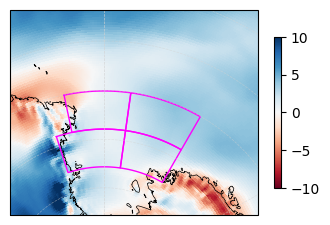

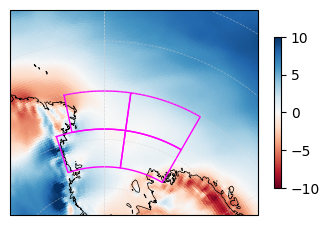

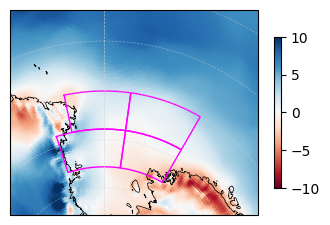

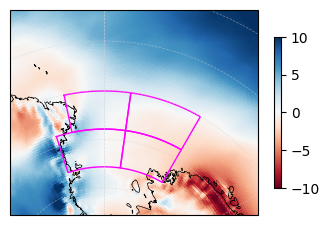

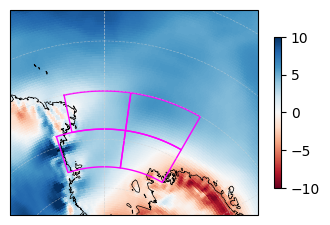

In [82]:
for i in range(6, len(time_era), 12):
    print(time_era[i])

    fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})

    # lons = np.arange(-180, -89)

    field = 'u10'
    # data = np.nanmean((np.array(nc.variables[field]))[i, 0, :, :], axis = 0)

    data = np.array(nc.variables[field])[i, 0, :, :]

    vmin, vmax = {}, {};
    vmin['siconc'] = 0.0; vmax['siconc'] = 1.0
    vmin['v10'] = -10; vmax['v10'] = 10
    vmin['u10'] = -10; vmax['u10'] = 10
    vmin['fb_mode2'] = 0.0; vmax['fb_mode2'] = 0.5
    vmin['fr_ridge'] = 0.0; vmax['fr_ridge'] = 10
    vmin['fb_mean'] = 0.0; vmax['fb_mean'] = 0.8
    vmin['fb_median'] = 0.0; vmax['fb_median'] = 0.8
    vmin['fb_std'] = 0.0; vmax['fb_std'] = 0.5
    vmin['fr_lead'] = 0.0; vmax['fr_lead'] = 0.02
    vmin['h_ridge_mean'] = 0.6; vmax['h_ridge_mean'] = 1.0

    pm = ax.pcolormesh(xx, yy, data, cmap = "RdBu", vmin = vmin[field], vmax = vmax[field])

    ax.coastlines('10m', linewidth = 0.5)

    ax.plot(NW_x, NW_y, lw=1, color = "magenta")
    ax.plot(NE_x, NE_y, lw=1, color = "magenta")
    ax.plot(SW_x, SW_y, lw=1, color = "magenta")
    ax.plot(SE_x, SE_y, lw=1, color = "magenta")

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False

    xmin, xmax = ax.set_xlim(1100000, -1800000)
    ymin, ymax = ax.set_ylim(-800000, -3200000)

    plt.colorbar(pm, ax = ax, shrink = 0.5)

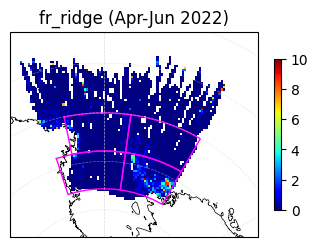

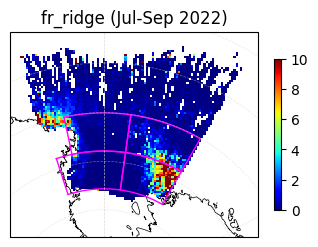

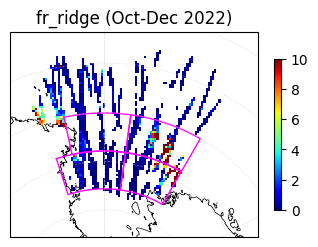

In [66]:
# Draw map ===========================================================

for i in range(0, len(time_era)):
    
    fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})

    lons = np.arange(-180, -89)
    
    field = 'wind'
    data = np.nanmean((np.array(nc.variables[field2]))[i, :, :], axis = 0)
    
    vmin, vmax = {}, {};
    vmin['fb_mode'] = 0.0; vmax['fb_mode'] = 0.5
    vmin['fb_mode1'] = 0.0; vmax['fb_mode1'] = 0.5
    vmin['fb_mode2'] = 0.0; vmax['fb_mode2'] = 0.5
    vmin['fr_ridge'] = 0.0; vmax['fr_ridge'] = 10
    vmin['fb_mean'] = 0.0; vmax['fb_mean'] = 0.8
    vmin['fb_median'] = 0.0; vmax['fb_median'] = 0.8
    vmin['fb_std'] = 0.0; vmax['fb_std'] = 0.5
    vmin['fr_lead'] = 0.0; vmax['fr_lead'] = 0.02
    vmin['h_ridge_mean'] = 0.6; vmax['h_ridge_mean'] = 1.0

    pm = ax.pcolormesh(xx, yy, data, cmap = "jet")
    
    ax.coastlines('10m', linewidth = 0.5)
    
    ax.plot(NW_x, NW_y, lw=1, color = "magenta")
    ax.plot(NE_x, NE_y, lw=1, color = "magenta")
    ax.plot(SW_x, SW_y, lw=1, color = "magenta")
    ax.plot(SE_x, SE_y, lw=1, color = "magenta")

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')
    
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False

    xmin, xmax = ax.set_xlim(1100000, -1800000)
    ymin, ymax = ax.set_ylim(-800000, -3200000)
    
    ax.set_title("{0} ({1}-{2})".format(field2, date1[i].strftime("%b"), date2[i].strftime("%b %Y")),
                   fontsize = 12)
    
    plt.colorbar(pm, ax = ax, shrink = 0.5)
    plt.savefig("F:\\2022_Ross\\Figures_map\\{0}_{1}-{2}.png".format(field2, date1[i].strftime("%Y%m"), date2[i].strftime("%Y%m")),
               bbox_inches="tight")

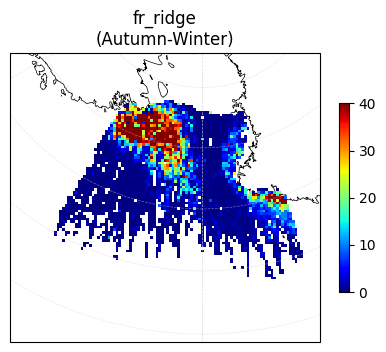

In [383]:
# Draw map ===========================================================

date1 = [dt.datetime(2020,3,1), dt.datetime(2020,9,1)]
date2 = [dt.datetime(2020,6,30), dt.datetime(2020,12,31)]
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})

tidx1 = (times >= date1[0]) & (times <= date2[0])
tidx2 = (times >= date1[1]) & (times <= date2[1])


lons = np.arange(-180, -89)

ax.coastlines('10m', linewidth = 0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False

data1 = np.array(nc.variables[field])[tidx1, :, :]
data2 = np.array(nc.variables[field])[tidx2, :, :]

pm = ax.pcolormesh(xx, yy, (np.nanmax(data2, axis=0) - np.nanmin(data1, axis=0)).transpose(),
                   cmap = "jet", vmin = 0, vmax = 40)

xmin, xmax = ax.set_xlim(-1800000, 1100000)
ymin, ymax = ax.set_ylim(-3200000, -800000)

ax.set_title("{0}\n({1}-{2})".format(field, "Autumn", "Winter"),
               fontsize = 12)

plt.colorbar(pm, ax = ax, shrink = 0.5)

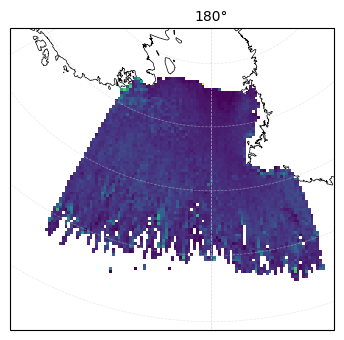

In [255]:
# Draw map version 2 ===========================================================
fig = plt.figure(figsize=(8,4), dpi= 100)
ax = plt.axes(projection=ccrs.SouthPolarStereo())

lons = np.arange(-180, -89)
# ax.plot(lons, np.ones(len(lons))*(-65), transform=ccrs.PlateCarree(), lw=2, color = "y")
# ax.plot([-180, -180], [-65, -78], transform=ccrs.PlateCarree(), lw=2, color = "y")
# ax.plot([-90, -90], [-65, -73], transform=ccrs.PlateCarree(), lw=2, color = "y")

# ax.add_feature(cartopy.feature.LAND)
# # ax.add_feature(cartopy.feature.BORDERS)
# ax.add_feature(cartopy.feature.OCEAN, color = (0,0,0.3))

# # import cartopy.feature as cfeature
# ice_shelves = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', '10m')
# ax.add_feature(ice_shelves, facecolor = "w", edgecolor='k', linewidth=0.5, linestyle='-')
# # ax.add_feature(cartopy.feature.COASTLINE)

ax.coastlines('10m', linewidth = 0.5)

# sc = ax.scatter(df2['lon'], df2['lat'], c=df2[field], cmap=cmap, s = 10,
#                 vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), marker = "o", facecolors='none')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

# gl.xlocator = mticker.FixedLocator(np.arange(-180,180,15))
# gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

ax.pcolormesh(xx, yy, np.nanmean(fb_mode, axis = 0).transpose())

xmin, xmax = plt.xlim(-1800000, 1100000)
ymin, ymax = plt.ylim(-3200000, -800000)

In [324]:
xp = np.arange(-2000000, 1500001, 25000)
yp = np.arange(-3200000, -800001, 25000)

xx, yy = np.meshgrid(xp, yp)
lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy) 

x_len = len(xp)
y_len = len(yp)

wide = 25000

polygons = []
for x0 in xp[:]:
    for y0 in yp[:]:
        polygons.append(Polygon([(x0,y0), (x0+wide, y0), (x0+wide, y0+wide), (x0, y0+wide)]))

grid = geopandas.GeoDataFrame({'geometry':polygons})
grid['id'] = grid.index

In [10]:
grid

,geometry,id
0,"POLYGON ((-2000000.000 -3200000.000, -1975000....",0
1,"POLYGON ((-2000000.000 -3175000.000, -1975000....",1
2,"POLYGON ((-2000000.000 -3150000.000, -1975000....",2
3,"POLYGON ((-2000000.000 -3125000.000, -1975000....",3
4,"POLYGON ((-2000000.000 -3100000.000, -1975000....",4
...,...,...
13531,"POLYGON ((1500000.000 -925000.000, 1525000.000...",13531
13532,"POLYGON ((1500000.000 -900000.000, 1525000.000...",13532
13533,"POLYGON ((1500000.000 -875000.000, 1525000.000...",13533
13534,"POLYGON ((1500000.000 -850000.000, 1525000.000...",13534


In [359]:
grid

,geometry,id
0,"POLYGON ((-2000000.000 -3200000.000, -1975000....",0
1,"POLYGON ((-2000000.000 -3175000.000, -1975000....",1
2,"POLYGON ((-2000000.000 -3150000.000, -1975000....",2
3,"POLYGON ((-2000000.000 -3125000.000, -1975000....",3
4,"POLYGON ((-2000000.000 -3100000.000, -1975000....",4
...,...,...
13531,"POLYGON ((1500000.000 -925000.000, 1525000.000...",13531
13532,"POLYGON ((1500000.000 -900000.000, 1525000.000...",13532
13533,"POLYGON ((1500000.000 -875000.000, 1525000.000...",13533
13534,"POLYGON ((1500000.000 -850000.000, 1525000.000...",13534


In [402]:
NW = (lat>-74) & (lat<-70) & ((lon<-172) | (lon>168))
SW = (lat>-78) & (lat<-74) & ((lon<-172) | (lon>168))
SE = (lat>-78) & (lat<-74) & ((lon<-150) & (lon>-172))
NE = (lat>-74) & (lat<-70) & ((lon<-150) & (lon>-172))

(96, 141)

In [489]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3031")

In [503]:
offset = 0.5

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

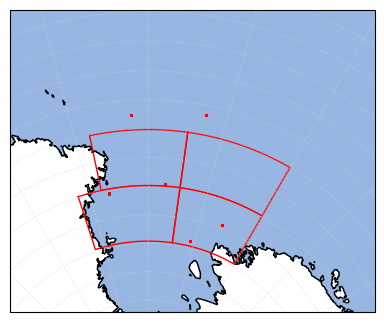

In [506]:


# Draw map version 2 ===========================================================
fig = plt.figure(figsize=(8,4), dpi= 100)
ax = plt.axes(projection=ccrs.SouthPolarStereo())

lons = np.arange(-180, -89)

# pm = ax.pcolormesh(xx, yy, grid["id"].values.reshape(np.shape(yy)), alpha = 0.8)
# pm = grid.plot("id", ax = ax)

for i in [5444, 5889, 6409, 7159, 8193, 8890]:
    point = grid[grid["id"] == i]
    point.plot(ax = ax, color ="r")
    
# fig.colorbar(pm)

ax.coastlines('10m', linewidth = 1)
# ax.fill_continents(color='lightgray',lake_color='white')
ax.add_feature(cartopy.feature.OCEAN)

# lons = np.concatenate((np.arange(160, 180), np.arange(-180, -150))) #np.arange(160, 180).append(np.arange(-180, -150))
ax.plot(NW_x, NW_y, lw=1, color = "r")
ax.plot(NE_x, NE_y, lw=1, color = "r")
ax.plot(SW_x, SW_y, lw=1, color = "r")
ax.plot(SE_x, SE_y, lw=1, color = "r")
# ax.plot([-180, -180], [-65, -78], transform=ccrs.PlateCarree(), lw=2, color = "y")
# ax.plot([-90, -90], [-65, -73], transform=ccrs.PlateCarree(), lw=2, color = "y")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

gl.xlocator = mticker.FixedLocator(np.arange(-180,180,15))
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,2))
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER


xmin, xmax = ax.set_xlim(1100000, -1800000)
ymin, ymax = ax.set_ylim(-800000, -3200000)

In [413]:
np.concatenate((np.arange(160, 180), np.arange(-180, -150)))

array([ 160,  161,  162,  163,  164,  165,  166,  167,  168,  169,  170,
        171,  172,  173,  174,  175,  176,  177,  178,  179, -180, -179,
       -178, -177, -176, -175, -174, -173, -172, -171, -170, -169, -168,
       -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157,
       -156, -155, -154, -153, -152, -151])

## Draw scatter plot of kriging estimation

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
from scipy import stats
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression

def MBE(x, y): # ----------------------------------------------------------------
    # Calculate Mean absolute difference between 2 variabes
    # x and y should have same dimensions
    value = 0   
    if len(x) == len(y):
        if len(x) > 0:
            for i in range(0,len(x)):
                value = value + x[i]-y[i]
            value = value / len(x)
    return value

def RMSE(x, y, r = False): # ----------------------------------------------------------------
    # Calculate Mean difference between 2 variabes
    # x and y should have same dimensions
    # x: estimate value, y: true value
    value = 0   
    if len(x) == len(y):
        if len(x) > 0:
            for i in range(0,len(x)):
                value = value + (x[i]-y[i])**2
            value = (value / len(x))**0.5
    if r:
        value = value/np.mean(y)*100
    return value

filename = r"F:\2022_Ross\ATL10_shp_Ross_10km_mode\Weekly_merge\Kriging_test\Scatter\Kriging_result_maxlag_EXPONENTIAL_10.csv"
df = pd.read_csv(filename, index_col = 0);

x = df['predict']
y = df['measure']

# model = LinearRegression().fit(x, y) 
a, b, r_value, pvalue, stderr = stats.linregress(x, y)


0.0

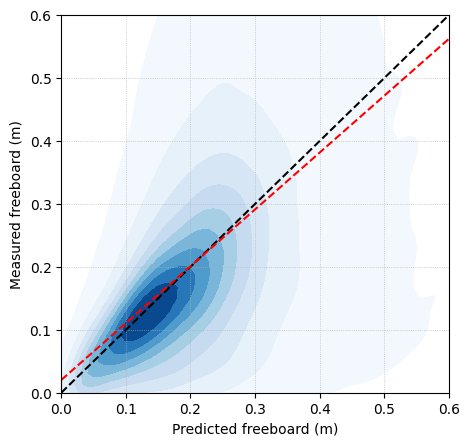

In [21]:
plt.figure(figsize = (5,5), dpi = 100)
# Plotting the KDE Plot 
sns.kdeplot(df['predict'], df['measure'],
            color='r', shade=True, Label='iris_virginica', 
            cmap="Blues", shade_lowest=False)

# plt.scatter(df['predict'], df['measure'])
xd = np.arange(0, 2)
yd = a*xd + b

plt.plot(xd, xd, color = 'k', ls = "--")
plt.plot(xd, yd, color = 'r', ls = "--")

plt.xlim(0, 0.6)
plt.ylim(0, 0.6)
plt.xlabel("Predicted freeboard (m)")
plt.ylabel("Measured freeboard (m)")
plt.grid(ls = ":", lw = 0.5)

In [23]:
from scipy.stats import gaussian_kde
kernel = gaussian_kde(np.vstack([x, y]))
c = kernel(np.vstack([x, y]))

In [26]:
filename = r"F:\2022_Ross\ATL10_shp_Ross_10km_mode\Weekly_merge\Kriging_test\Scatter\Kriging_result_maxlag_EXPONENTIAL_10_add.csv"
df['density'] = c
df.to_csv(filename)

In [3]:
filename = r"F:\2022_Ross\ATL10_shp_Ross_10km_mode\Weekly_merge\Kriging_test\Scatter\Kriging_result_maxlag_EXPONENTIAL_10_add.csv"
df = pd.read_csv(filename, index_col = 0).reset_index(drop=True)

x = df['predict'].values
y = df['measure'].values

# model = LinearRegression().fit(x, y) 
a, b, r_value, pvalue, stderr = stats.linregress(x, y)

# plt.figure(figsize = (4.5,3.5))

# plt.scatter(df['predict'], df['measure'], s = 5, c = df['density'], cmap = "Blues")
# plt.colorbar(shrink = 0.7, label = "Kernel Density")

# # plt.scatter(df['predict'], df['measure'])
# xd = np.arange(0, 2)
# yd = a*xd + b

# plt.plot(xd, xd, color = 'k', ls = "--")
# plt.plot(xd, yd, color = 'r', ls = "--")

# rmse = RMSE(x,y)
# mbe = MBE(x,y)


# plt.xlim(0, 0.5)
# plt.ylim(0, 0.5)
# plt.xlabel("Predicted freeboard (m)")
# plt.ylabel("Measured freeboard (m)")
# plt.grid(ls = ":", lw = 0.5)
# plt.text(0.02, 0.46, "y={0:.2f}x+{1:.2f}".format(a,b), fontsize = 12)
# plt.text(0.02, 0.42, "R={0:.2f} (p={1:.2f})".format(r_value, pvalue), fontsize = 12)
# plt.text(0.02, 0.38, "RMSD={0:.2f} m".format(rmse), fontsize = 12);
# plt.text(0.02, 0.34, "MBD={0:.2f} m".format(mbe), fontsize = 12);

In [7]:
import datetime as dt

In [96]:
df.reset_index(drop=True)

,predict,measure,date,lat,lon,range,nugget,sill,model,density
0,0.374874,0.232593,20181011,-76.125864,-160.953367,22088.755096,1.892412e-02,0.022432,EXPONENTIAL,1.234264
1,0.351002,0.216410,20181011,-75.823910,-161.158688,22088.755096,1.892412e-02,0.022432,EXPONENTIAL,1.894745
2,0.339860,0.170669,20181011,-75.764649,-161.198086,22088.755096,1.892412e-02,0.022432,EXPONENTIAL,2.164601
3,0.297999,0.033605,20181011,-75.590640,-161.312144,22088.755096,1.892412e-02,0.022432,EXPONENTIAL,1.509314
4,0.289343,0.107658,20181011,-75.527436,-161.352964,22088.755096,1.892412e-02,0.022432,EXPONENTIAL,3.352319
...,...,...,...,...,...,...,...,...,...,...
134998,0.438216,0.098800,20220929,-76.022241,169.964929,5186.566748,4.993491e-12,0.025489,EXPONENTIAL,0.446674
134999,0.196664,0.098077,20220929,-76.345557,169.746737,5186.566748,4.993491e-12,0.025489,EXPONENTIAL,10.783542
135000,0.168621,0.016339,20220929,-76.785146,169.434994,5186.566748,4.993491e-12,0.025489,EXPONENTIAL,4.417862
135001,0.182478,0.153200,20220929,-76.847380,169.389385,5186.566748,4.993491e-12,0.025489,EXPONENTIAL,21.732053


In [105]:
for i in range(0, len(df)):
    df.loc[i, "datetime"] = dt.datetime.strptime(str(df.loc[i, "date"]), "%Y%m%d")
    df.loc[i, "year"] = df.loc[i, "datetime"].year
    df.loc[i, "month"] = df.loc[i, "datetime"].month
    df.loc[i, "day"] = df.loc[i, "datetime"].day
    

In [22]:
def get_errors(df):
    rmse = RMSE(df['predict'].values, df['measure'].values)
    mbe = MBE(df['predict'].values, df['measure'].values)
    r = np.corrcoef(df['predict'].values, df['measure'].values)[1,0]
    k_range = df['range'].mean()
    sill = df['sill'].mean()
    df2 = pd.DataFrame({"rmse": [rmse], "mbe": [mbe], 'R': [r], 'range': [k_range], 'sill': [sill]})
    return df2

In [23]:
dfw = df.groupby(by = "date").apply(get_errors).reset_index(drop = False)

for i in range(0, len(dfw)):
    dfw.loc[i, "datetime"] = dt.datetime.strptime(str(dfw.loc[i, "date"]), "%Y%m%d")
    dfw.loc[i, "year"] = dfw.loc[i, "datetime"].year
    dfw.loc[i, "month"] = dfw.loc[i, "datetime"].month
    dfw.loc[i, "day"] = dfw.loc[i, "datetime"].day

In [24]:
dfw

,date,level_1,rmse,mbe,R,range,sill,datetime,year,month,day
0,20181011,0,0.186579,-0.001157,0.514804,22088.755096,0.022432,2018-10-11,2018.0,10.0,11.0
1,20181018,0,0.199457,-0.019331,0.516799,16906.365979,0.022446,2018-10-18,2018.0,10.0,18.0
2,20181025,0,0.187033,-0.003148,0.520928,5902.060655,0.027141,2018-10-25,2018.0,10.0,25.0
3,20181101,0,0.160175,0.014163,0.595894,8332.727885,0.039017,2018-11-01,2018.0,11.0,1.0
4,20181108,0,0.134151,-0.003444,0.363291,8628.980005,0.015722,2018-11-08,2018.0,11.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
171,20220901,0,0.167714,-0.002048,0.480783,4671.533035,0.021366,2022-09-01,2022.0,9.0,1.0
172,20220908,0,0.184543,-0.002461,0.514361,7425.235324,0.018908,2022-09-08,2022.0,9.0,8.0
173,20220915,0,0.175878,-0.004542,0.542750,145443.078771,0.029156,2022-09-15,2022.0,9.0,15.0
174,20220922,0,0.134896,0.002393,0.533489,6305.864356,0.017237,2022-09-22,2022.0,9.0,22.0


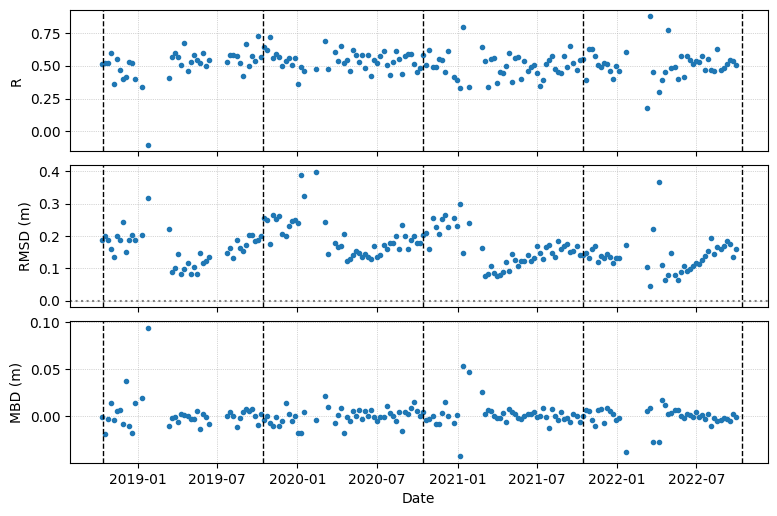

In [211]:
fig, ax = plt.subplots(3,1,figsize = (9,6), dpi = 100, sharex = True)
plt.subplots_adjust(hspace=0.1, wspace = 0.0)
ax[0].plot(dfw['datetime'], dfw['R'], '.')
ax[0].set_ylabel("R")

ax[1].plot(dfw['datetime'], dfw['rmse'], '.')
ax[1].set_ylabel("RMSD (m)")
ax[1].axhline(0, color = "gray", ls = ":")

ax[2].plot(dfw['datetime'], dfw['mbe'], '.')
ax[2].set_ylabel("MBD (m)")

ax[2].set_xlabel("Date")

for i in range(0, len(ax)):
    for year in [2018, 2019, 2020, 2021, 2022]:
        ax[i].axvline(dt.datetime(year, 10, 14), color = 'k', ls = "--", lw = 1.0)
        ax[i].grid(ls=":", lw=0.5)

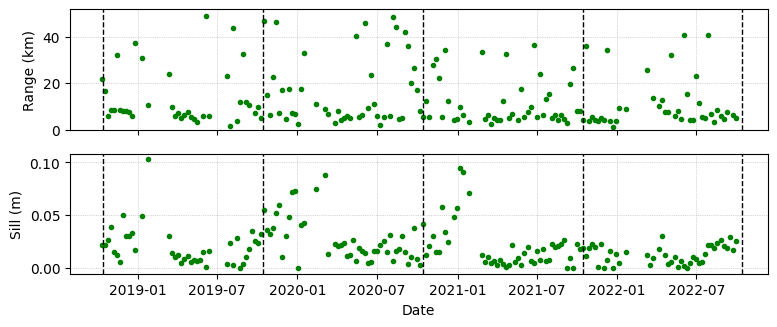

In [35]:
fig, ax = plt.subplots(2,1,figsize = (9,3.5), dpi = 100, sharex = True)

ax[0].plot(dfw['datetime'], dfw['range']/1000, '.', color = "g")
ax[0].set_ylabel("Range (km)")
ax[0].set_ylim(0, 52)

ax[1].plot(dfw['datetime'], dfw['sill'], '.', color = "g")
ax[1].set_ylabel("Sill (m)")

ax[1].set_xlabel("Date")


for i in range(0, len(ax)):
    for year in [2018, 2019, 2020, 2021, 2022]:
        ax[i].axvline(dt.datetime(year, 10, 14), color = 'k', ls = "--", lw = 1.0)
        ax[i].grid(ls=":", lw=0.5)

In [37]:
np.median(dfw['range']), np.median(dfw['sill'])

(7825.566234541488, 0.0159872786356368)

In [213]:
fb

,date,fb_mean,fb_std,sector,variogram,SIT
0,2018-10-11,0.169783,0.087392,NE,aex,0.625968
1,2018-10-18,0.180205,0.050329,NE,aex,0.651503
2,2018-10-25,0.209209,0.052745,NE,aex,0.722563
3,2018-11-01,0.203691,0.050446,NE,aex,0.709043
4,2018-11-08,0.187686,0.029222,NE,aex,0.669831
...,...,...,...,...,...,...
171,2022-09-01,0.293382,0.119247,NE,aex,0.928785
172,2022-09-08,0.282646,0.113455,NE,aex,0.902483
173,2022-09-15,0.292284,0.102836,NE,aex,0.926096
174,2022-09-22,0.299475,0.085384,NE,aex,0.943713


Text(0, 0.5, 'Freeboard (m)')

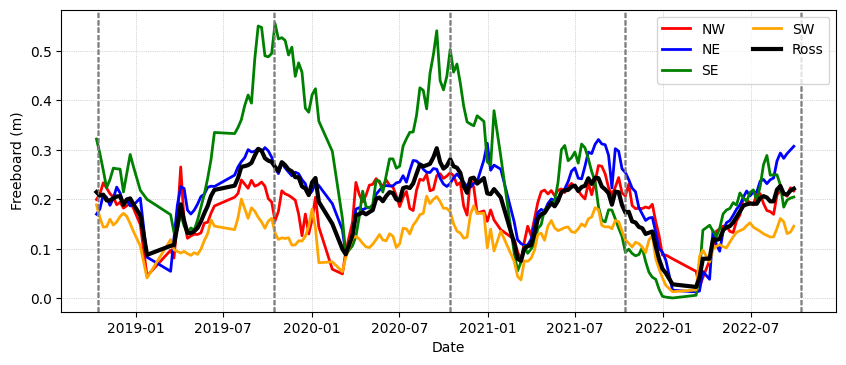

In [228]:
regions = ["NW", "NE", "SE", "SW", "Ross"]
colors = ["red", "blue", "green", "orange", "k"]
plt.subplots(1,1,figsize = (10, 4), dpi = 100)

for i, region in enumerate(regions):    
    fb = pd.read_csv("F:\\2022_Ross\\Kriging_maps\\Freeboard_smooth_{0}.csv".format(region), index_col = 0)
    fb['date'] = pd.to_datetime(fb['date'])
    if region == "Ross":
        lw = 3
    else:
        lw = 2
    plt.plot(fb["date"], fb["fb_mean"], color = colors[i], lw = lw, label = region)
    
    for year in [2018, 2019, 2020, 2021, 2022]:
        plt.axvline(dt.datetime(year, 10, 14), color = 'grey', ls = "--", lw = 1.0)

plt.legend(ncol = 2)
plt.grid(ls=":", lw=0.5)
plt.xlabel("Date")
plt.ylabel("Freeboard (m)")